# Analyse des occupations et des profils des acteurs à l'époque moderne et contemporaine 

Dans ce carnet la méthode d'analyse de correspondances multiples est appliquée afin de mettre en évidence les profils des acteurs dans le champ scientifique de l'astronomie et de la physique.

Pour des raisons d'effectifs et de cohérence culturelle l'analyse est effectuée sur les époques moderne (avant 1801) et contemporaine (après 1801) séparément

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql


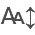

In [3]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [4]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

## Importer les données à analyser

On exécute une requête SQL sur la base de données qui recompose les données et effectue un premier codage.

In [5]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/astronomers_import.db')
cn

In [6]:
qr = """
WITH tw1 as (
SELECT DISTINCT wp.personUri, wp.personLabel, 
   -- avec l'instruction CASE on code le genre
   CASE 
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581097'
       THEN 'M'
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581072'
       THEN 'F'
       ELSE 'A'
   END AS gender, wp.birthYear, ga.label, od.label domaine
FROM wdt_person_occupation po 
    JOIN wdt_occupation wo ON po.occupationUri = wo.wdt_uri
    JOIN wdt_personne wp ON wp.personUri = po.personUri 
    JOIN occupation_domain od ON od.pk_occupation_domain = wo.fk_domain
    JOIN wdt_person_citizenship wpc
	 ON wpc.personUri = wp.personUri
    JOIN wdt_country wc 
     ON wc.wdt_uri = wpc.nationaliteUri 
    JOIN geographic_area ga
     ON ga.pk_geographic_area = wc.fk_geographic_area
ORDER BY wp.personUri, od.label )
SELECT personUri, personLabel,gender, birthYear, count(*) as eff, group_concat(domaine), max(label) AS area_label
FROM tw1
GROUP BY personUri, personLabel, birthYear
"""

In [7]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()

In [8]:
### Inspection des premières lignes
print(len(l))
l[:3]

23830


[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'M',
  '1929',
  1,
  'Astronomie',
  'Espace_germanique'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'M',
  '1892',
  2,
  'Enseignant,Physique',
  'Amérique_nord'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'M',
  '1924',
  4,
  'Enseignant,Enseignant,Physique,Physique',
  'Espace_germanique')]

In [9]:
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'gender', 'annee_nais',
                     'eff_occupations', 'liste_occup', 'origine_geog'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23830 entries, 0 to 23829
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              23830 non-null  object
 1   nom              23830 non-null  object
 2   gender           23830 non-null  object
 3   annee_nais       23830 non-null  object
 4   eff_occupations  23830 non-null  int64 
 5   liste_occup      23830 non-null  object
 6   origine_geog     23830 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [10]:
### Inspection des données 
show(df_orig[df_orig.annee_nais < '1901' ].sort_values(by='annee_nais', ascending=True), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [11]:
### Distribution du nombre d'occupations par personne:
# combien de personnes ont plus qu'une occupation?
# Période contemporaine

dfs = df_orig[(df_orig.annee_nais > '1800') & (df_orig.annee_nais < '1981') ].groupby(by='eff_occupations')\
    .size()
print('Total:', sum(dfs))
dfs

Total: 21261


eff_occupations
1     9399
2     7384
3     2587
4     1199
5      221
6      289
7       20
8       86
9       20
10      32
12      15
14       2
15       5
18       1
24       1
dtype: int64

In [12]:
### Distribution du nombre d'occupations par personne
# Période moderne

dfs = df_orig[(df_orig.annee_nais < '1801') ].groupby(by='eff_occupations')\
    .size()
print('Total:', sum(dfs))
dfs

Total: 1827


eff_occupations
1     303
2     476
3     420
4     288
5     151
6     107
7      27
8      30
9       7
10      8
11      1
12      8
18      1
dtype: int64

## Codage des occupations

### Création de la fonction de codage

On choisit parmi les modalités de la variable trois catégories dont le sens est différent:
* la première est la catégorie principale, celle qui a permis de constituer la population
* la deuxième est plus liée à la notion d'activité et non de domaine scientifique
* la troisième, comme la première, relève du domaine scientifique


À noter que l'ordre des disciplines compte: le fonction qu'on va construire utilise toujours la première modalité rencontrée pour chaque catégorie, et cesse ensuite de chercher.


Dans le choix de l'ordre on a choisi ici de mettre en premier les modalités rares ou plus intéressantes dans une logique de domaine d'études mais on pourrait faire autrement et on consruit ici __un modèle de codage__ qui n'est pas absolu et qu'il faudra expliciter dans le rendu du travail car il influence les résultats.

In [13]:
# Disciplines principales, disc_princ
a = ['Astrologie', 'Astronomie', 'Physique']

# Activités, activites
b = ['Clerc', 'Ingenieur', 'Chercheur',  'Politique_droit', 'Economie','Enseignant']

# Autres disciplines, disc_autres
c = ['Medecine', 'Philosophie', 'Lettres', 'Arts',  'SHS', 'Pharmacie_chimie', 'Autres_sciences','Mathematiques']


In [14]:
### Ajout de colonnes supplémentaires sur toute la table

## Dans la fonction, on met la liste à coder (l) et les listes des objets en argument

def coder(l, a, b, c):
    
    ll = []

    ## si il n'y a pas d'autres disciplines
    # complète avec disciplines principales additionnelles
    d = c + a

    for e in l:

        e = list(e)
        
        o1 = ''
        for el in a:
            # dès que la variable o1 est remplie sort de la boucle
            if el in e[5] and len(o1) == 0:
                o1 = el
                e.append('d1_'+ el)   
        if not(len(o1) > 0):
            e.append('d1_nr')

        o2 = ''
        for el in b:
            if el in e[5] and len(o2) == 0:
                o2 = el
                e.append('d2_'+ o2)
        if not(len(o2) > 0):
            e.append('d2_nr')


        o3 = ''
        for el in d:
            if el in e[5] and len(o3) == 0\
                    and el != o1:
                o3 = el
                e.append('d3_'+ o3)
        if not(len(o3) > 0):
            e.append('d3_nr')

        o4 = ''
        for el in d:
            if len(o4) == 0 and el in e[5]\
                    and el != o3 and el != o1:
                o4 = el
                e.append('d4_'+ o4)
        if not(len(o4) > 0):
            e.append('d4_nr')

        ll.append(e)

    return ll

In [15]:
ll = coder(l, a, b, c)

In [16]:
pprint.pprint(ll[103:110])

[['http://www.wikidata.org/entity/Q101562988',
  'Paul Koenig',
  'M',
  '1917',
  2,
  'Enseignant,Physique',
  'Amérique_nord',
  'd1_Physique',
  'd2_Enseignant',
  'd3_nr',
  'd4_nr'],
 ['http://www.wikidata.org/entity/Q101578914',
  'Valeska Zambra',
  'F',
  '1994',
  2,
  'Chercheur,Physique',
  'Amérique_latine',
  'd1_Physique',
  'd2_Chercheur',
  'd3_nr',
  'd4_nr'],
 ['http://www.wikidata.org/entity/Q101728',
  'Michael Rossmann',
  'M',
  '1930',
  6,
  'Chercheur,Chercheur,Enseignant,Enseignant,Physique,Physique',
  'Espace_germanique',
  'd1_Physique',
  'd2_Chercheur',
  'd3_nr',
  'd4_nr'],
 ['http://www.wikidata.org/entity/Q101869',
  'Herbert Spohn',
  'M',
  '1946',
  3,
  'Enseignant,Mathematiques,Physique',
  'Espace_germanique',
  'd1_Physique',
  'd2_Enseignant',
  'd3_Mathematiques',
  'd4_nr'],
 ['http://www.wikidata.org/entity/Q101884689',
  'Bolesław Buszczyński',
  'M',
  '1857',
  2,
  'Astronomie,Autres_sciences',
  'Europe_centrale',
  'd1_Astronomie',
 

In [17]:
len(l),len(ll), ll[301:305]

(23830,
 23830,
 [['http://www.wikidata.org/entity/Q10288979',
   'George Yuri Rainich',
   'M',
   '1886',
   1,
   'Physique',
   'Amérique_nord',
   'd1_Physique',
   'd2_nr',
   'd3_nr',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q102894',
   'Ralf Bönt',
   'M',
   '1963',
   3,
   'Activites_diverses,Lettres,Physique',
   'Espace_germanique',
   'd1_Physique',
   'd2_nr',
   'd3_Lettres',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q10289525',
   'Gil da Costa Marques',
   'M',
   '1946',
   2,
   'Enseignant,Physique',
   'Amérique_latine',
   'd1_Physique',
   'd2_Enseignant',
   'd3_nr',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q10289868',
   'Giorgio Eugenio Oscare Giacaglia',
   'M',
   '1935',
   2,
   'Ingenieur,Physique',
   'Amérique_latine',
   'd1_Physique',
   'd2_Ingenieur',
   'd3_nr',
   'd4_nr']])

In [18]:
# La deuxième variable (a1) est considérée comme une activité et non une occupation
df_ll = pd.DataFrame(ll, columns=['uri', 'nom', 'genre', 'annee_nais',
                     'eff_occupations', 'liste_occup', 'origine_geog', 'o1', 'a1', 'o2', 'o3'])
df_ll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23830 entries, 0 to 23829
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              23830 non-null  object
 1   nom              23830 non-null  object
 2   genre            23830 non-null  object
 3   annee_nais       23830 non-null  object
 4   eff_occupations  23830 non-null  int64 
 5   liste_occup      23830 non-null  object
 6   origine_geog     23830 non-null  object
 7   o1               23830 non-null  object
 8   a1               23830 non-null  object
 9   o2               23830 non-null  object
 10  o3               23830 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [19]:
df_ll.groupby(by='o1').size().sort_values(ascending=False)

o1
d1_Physique      16850
d1_Astronomie     6427
d1_Astrologie      553
dtype: int64

In [20]:
df_ll.groupby(by='a1').size().sort_values(ascending=False)

a1
d2_nr                 13780
d2_Enseignant          5796
d2_Ingenieur           1525
d2_Chercheur           1509
d2_Politique_droit      807
d2_Clerc                293
d2_Economie             120
dtype: int64

In [21]:
df_ll[df_ll.o3 != 'd4_nr'].groupby(by='a1').size().sort_values(ascending=False)

a1
d2_nr                 556
d2_Enseignant         435
d2_Chercheur          155
d2_Ingenieur          151
d2_Clerc              104
d2_Politique_droit     74
d2_Economie            11
dtype: int64

In [22]:
df_ll.groupby(by='o2').size().sort_values(ascending=False)

o2
d3_nr                  17549
d3_Mathematiques        1496
d3_Autres_sciences      1319
d3_Lettres              1266
d3_Physique              724
d3_SHS                   421
d3_Philosophie           380
d3_Medecine              366
d3_Arts                  251
d3_Pharmacie_chimie       41
d3_Astronomie             17
dtype: int64

In [23]:
df_ll.groupby(by='o3').size().sort_values(ascending=False)

o3
d4_nr                  22344
d4_Mathematiques         475
d4_Autres_sciences       271
d4_Physique              229
d4_SHS                   193
d4_Lettres               159
d4_Arts                   86
d4_Philosophie            37
d4_Astronomie             25
d4_Pharmacie_chimie       11
dtype: int64

### Codage par période de cinquante ans

In [24]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_ll['annee_nais'] = df_ll['annee_nais'].astype(int)

In [25]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_ll[df_ll['annee_nais'] < 1981].copy(deep=True)
cdf_p.head(3)

uri                          nom  \
0    http://www.wikidata.org/entity/Q1000193                Hans Elsässer   
1    http://www.wikidata.org/entity/Q1000934  Charles Christian Lauritsen   
2  http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   

  genre  annee_nais  eff_occupations                              liste_occup  \
0     M        1929                1                               Astronomie   
1     M        1892                2                      Enseignant,Physique   
2     M        1924                4  Enseignant,Enseignant,Physique,Physique   

        origine_geog             o1             a1     o2     o3  
0  Espace_germanique  d1_Astronomie          d2_nr  d3_nr  d4_nr  
1      Amérique_nord    d1_Physique  d2_Enseignant  d3_nr  d4_nr  
2  Espace_germanique    d1_Physique  d2_Enseignant  d3_nr  d4_nr

In [26]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1360, 1980)

In [27]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_50 = list(range(1351, 2002, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1801, 1851, 1901, 1951, 2001])

In [28]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

uri                          nom  \
0    http://www.wikidata.org/entity/Q1000193                Hans Elsässer   
1    http://www.wikidata.org/entity/Q1000934  Charles Christian Lauritsen   
2  http://www.wikidata.org/entity/Q100153910               Frank J. Blatt   

  genre  annee_nais  eff_occupations                              liste_occup  \
0     M        1929                1                               Astronomie   
1     M        1892                2                      Enseignant,Physique   
2     M        1924                4  Enseignant,Enseignant,Physique,Physique   

        origine_geog             o1             a1     o2     o3   periodes  
0  Espace_germanique  d1_Astronomie          d2_nr  d3_nr  d4_nr  1901-1950  
1      Amérique_nord    d1_Physique  d2_Enseignant  d3_nr  d4_nr  1851-1900  
2  Espace_germanique    d1_Physique  d2_Enseignant  d3_nr  d4_nr  1901-1950

In [29]:
cdf_p[cdf_p.annee_nais == 1980][:3]

uri                     nom genre  \
48   http://www.wikidata.org/entity/Q100711748        Ivelina Momcheva     F   
773  http://www.wikidata.org/entity/Q106980807       Youngmin JeongAhn     M   
794  http://www.wikidata.org/entity/Q107088661  Alexander V. Shestakov     M   

     annee_nais  eff_occupations        liste_occup          origine_geog  \
48         1980                1         Astronomie       Europe_centrale   
773        1980                1         Astronomie  Asie_orientale_Chine   
794        1980                2  Economie,Physique                Russie   

                o1           a1     o2     o3   periodes  
48   d1_Astronomie        d2_nr  d3_nr  d4_nr  1951-2000  
773  d1_Astronomie        d2_nr  d3_nr  d4_nr  1951-2000  
794    d1_Physique  d2_Economie  d3_nr  d4_nr  1951-2000

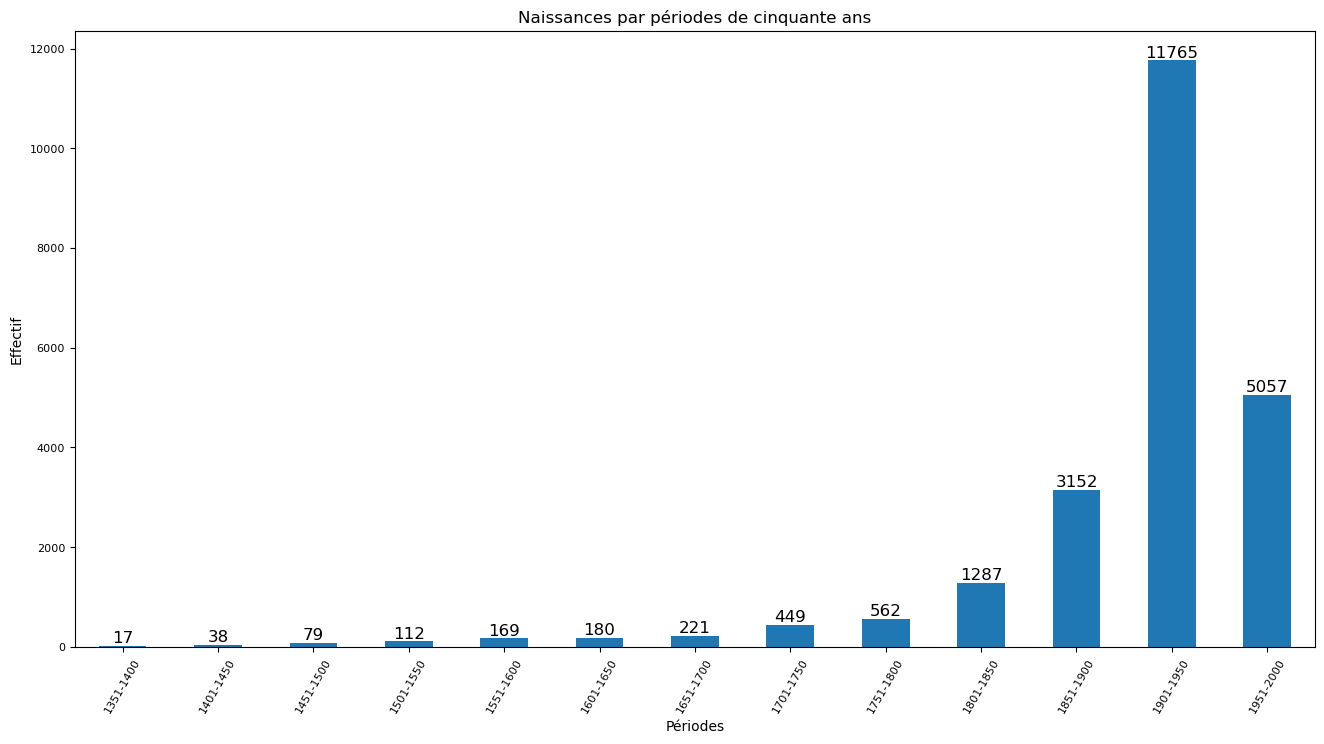

In [30]:
### compter les naissances par périodes de 50 ans
ax = cdf_p.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

## MCA de la période avant 1801

### Tableau à analyser

Étant donné qu'on a observé de grandes différences d'effectifs pour les différentes périodes, on sépare deux périodes: une avant 1801 (appelée moderne), l'autre à partir de cette date (appelée contemporaine). Et on les analyse séparément.


On explore d'abord la distribution des différentes variables pour la première période.



In [31]:
### On notera l'effectif trop important des individus pour lesquels cette variable
# n'est pas renseignée. Mieux vaudra ne pas l'utiliser
cdf_p[cdf_p.annee_nais < 1801].groupby(by='o3').size().sort_values(ascending=False)

o3
d4_nr                  1240
d4_Mathematiques        209
d4_Autres_sciences       86
d4_SHS                   79
d4_Physique              71
d4_Lettres               71
d4_Philosophie           33
d4_Astronomie            24
d4_Arts                  11
d4_Pharmacie_chimie       3
dtype: int64

In [32]:
df_d3 = cdf_p[cdf_p.annee_nais < 1801].groupby(by='o2').size().sort_values(ascending=False)
df_d3

o2
d3_nr                  543
d3_Mathematiques       419
d3_Medecine            214
d3_Lettres             162
d3_Autres_sciences     158
d3_Philosophie         152
d3_SHS                  90
d3_Physique             35
d3_Arts                 35
d3_Astronomie           15
d3_Pharmacie_chimie      4
dtype: int64

In [33]:
## exclure les modalités moins fréquentes
l_d3 = df_d3.index.to_list()[:-2]
print(l_d3)

['d3_nr', 'd3_Mathematiques', 'd3_Medecine', 'd3_Lettres', 'd3_Autres_sciences', 'd3_Philosophie', 'd3_SHS', 'd3_Physique', 'd3_Arts']


In [34]:
df_d2 = cdf_p[cdf_p.annee_nais < 1801].groupby(by='a1').size().sort_values(ascending=False)
df_d2

a1
d2_nr                 828
d2_Enseignant         332
d2_Ingenieur          205
d2_Clerc              189
d2_Chercheur          142
d2_Politique_droit    126
d2_Economie             5
dtype: int64

In [35]:
## exclure les modalités moins fréquentes
l_d2 = df_d2.index.to_list()[:-1]
print(l_d2)

['d2_nr', 'd2_Enseignant', 'd2_Ingenieur', 'd2_Clerc', 'd2_Chercheur', 'd2_Politique_droit']


In [36]:
cdf_p[cdf_p.annee_nais < 1801].groupby(by='o1').size().sort_values(ascending=False)

o1
d1_Astronomie    1043
d1_Physique       618
d1_Astrologie     166
dtype: int64

In [37]:
cdf_p[cdf_p.annee_nais < 1801].groupby(by='periodes', observed=True).size().sort_values(ascending=False)

periodes
1751-1800    562
1701-1750    449
1651-1700    221
1601-1650    180
1551-1600    169
1501-1550    112
1451-1500     79
1401-1450     38
1351-1400     17
dtype: int64

In [38]:
cdf_og = cdf_p[cdf_p.annee_nais < 1801].groupby(by='origine_geog', observed=True).size().sort_values(ascending=False)
cdf_og

origine_geog
Espace_germanique            504
France_Benelux               426
Iles_britanniques            286
Europe_méridionale           200
Europe_centrale              113
Scandinavie                  110
Russie                        67
Asie_orientale_Chine          44
Amérique_nord                 35
Moyen_Orient_Afrique_Nord     24
Amérique_latine                9
Asie_méridionale_Inde          5
Balkans                        4
dtype: int64

In [39]:
## exclure les modalités moins fréquentes
l_og = cdf_og.index.to_list()[:-3]
print(l_og)

['Espace_germanique', 'France_Benelux', 'Iles_britanniques', 'Europe_méridionale', 'Europe_centrale', 'Scandinavie', 'Russie', 'Asie_orientale_Chine', 'Amérique_nord', 'Moyen_Orient_Afrique_Nord']


### Préparer le tableau à analyser

Il est nécessaire de recoder le tableau pour ne pas avoir des variables avec modalités vides: on utilise donc un nouveau tableau avec les individus nés avant 1801.


Aussi, si on n'enlève pas les modalités les moins fréquentes (cf. distributions ci-dessus) elles impactent massivement l'analyse factorielle des correspondances multiples, car les modalités les moins fréquentes apportent le plus de variation. On doit donc inspecter manuellement les profils rares mais les exclure de l'ACM pour mettre en évidence des structures plus importantes.


Le bon dosage dépend des questions de recherche.

In [40]:
### Créer une copie indépendante du DataFrame 
# tout en éliminant les modalités peu fréquentes 
cdf_mod = df_ll[(df_ll['annee_nais'] < 1801)\
                & (df_ll.origine_geog.isin(l_og))\
                & (df_ll.a1.isin(l_d2))\
                & (df_ll.o2.isin(l_d3))]\
                    .copy(deep=True).reset_index(names='orig_index')
print(len(cdf_mod))
cdf_mod.head(3)

1785


orig_index                                        uri  \
0          13  http://www.wikidata.org/entity/Q100276765   
1          18     http://www.wikidata.org/entity/Q100346   
2          22  http://www.wikidata.org/entity/Q100374862   

                                     nom genre  annee_nais  eff_occupations  \
0                 Charles-Henri Tabareau     M        1790                1   
1                  Johann Heinrich Voigt     M        1613                2   
2  Muhammad ibn Abd al-Rahman al-Afaliqi     M        1688                3   

                     liste_occup               origine_geog             o1  \
0                       Physique             France_Benelux    d1_Physique   
1       Astronomie,Mathematiques          Espace_germanique  d1_Astronomie   
2  Astronomie,Enseignant,Lettres  Moyen_Orient_Afrique_Nord  d1_Astronomie   

              a1                o2     o3  
0          d2_nr             d3_nr  d4_nr  
1          d2_nr  d3_Mathematiques  d4_nr  
2  d2_Enseignant        d3_Lettres  d4_nr

In [41]:
max(cdf_mod.index)

1784

In [42]:
### Année minimale et maximale dans la population
min(cdf_mod['annee_nais']), max(cdf_mod['annee_nais'])

(1360, 1800)

In [43]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_50 = list(range(1351, 1802, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1601, 1651, 1701, 1751, 1801])

In [44]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_mod['periodes'] = pd.cut(cdf_mod['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_mod['periodes'] = cdf_mod['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_mod.head(3)

orig_index                                        uri  \
0          13  http://www.wikidata.org/entity/Q100276765   
1          18     http://www.wikidata.org/entity/Q100346   
2          22  http://www.wikidata.org/entity/Q100374862   

                                     nom genre  annee_nais  eff_occupations  \
0                 Charles-Henri Tabareau     M        1790                1   
1                  Johann Heinrich Voigt     M        1613                2   
2  Muhammad ibn Abd al-Rahman al-Afaliqi     M        1688                3   

                     liste_occup               origine_geog             o1  \
0                       Physique             France_Benelux    d1_Physique   
1       Astronomie,Mathematiques          Espace_germanique  d1_Astronomie   
2  Astronomie,Enseignant,Lettres  Moyen_Orient_Afrique_Nord  d1_Astronomie   

              a1                o2     o3   periodes  
0          d2_nr             d3_nr  d4_nr  1751-1800  
1          d2_nr  d3_Mathematiques  d4_nr  1601-1650  
2  d2_Enseignant        d3_Lettres  d4_nr  1651-1700

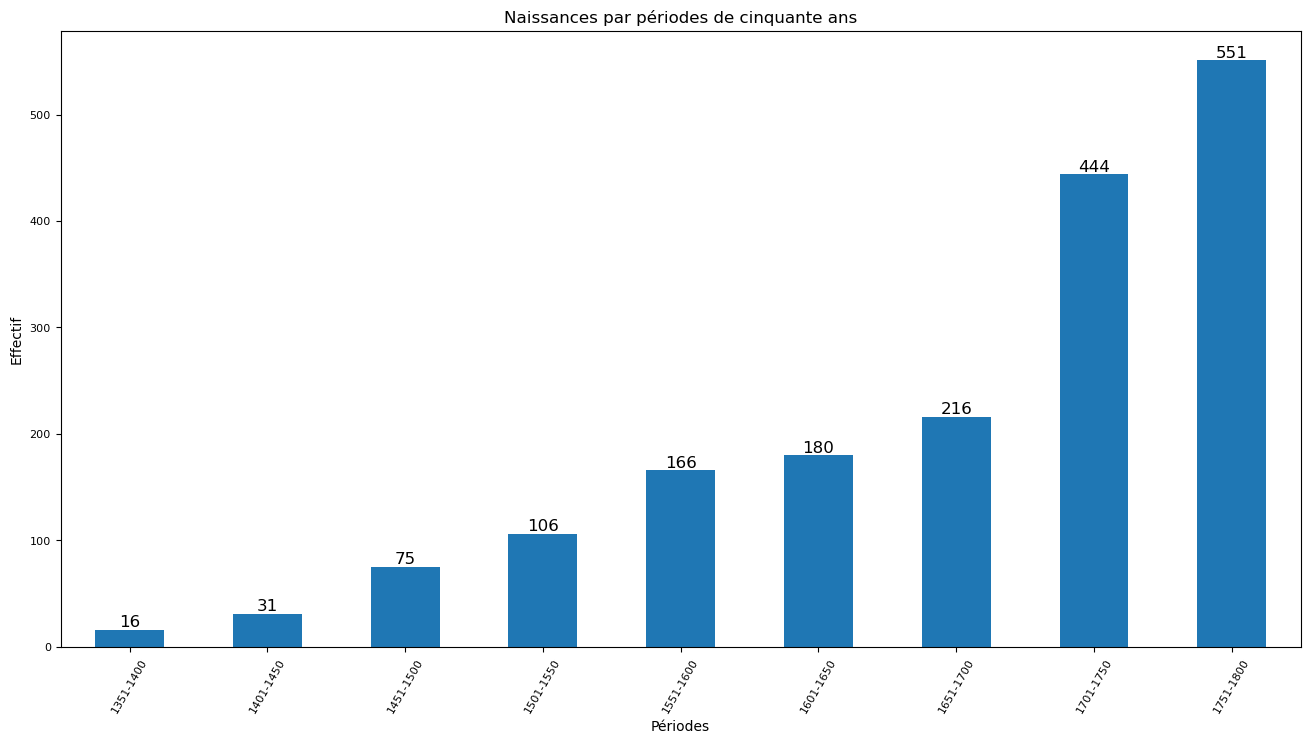

In [45]:
### compter les naissances par périodes de 50 ans
ax = cdf_mod.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

In [46]:
DActives = cdf_mod[['periodes', 'origine_geog',
 'o1', 'a1', 'o2']].copy(deep=True)

In [47]:
DActives.groupby(by='periodes', observed=False).size()

periodes
1351-1400     16
1401-1450     31
1451-1500     75
1501-1550    106
1551-1600    166
1601-1650    180
1651-1700    216
1701-1750    444
1751-1800    551
dtype: int64

In [48]:
DActives.groupby(by='origine_geog', observed=True).size().sort_values(ascending=False)


origine_geog
Espace_germanique            497
France_Benelux               425
Iles_britanniques            283
Europe_méridionale           196
Europe_centrale              111
Scandinavie                  108
Russie                        67
Asie_orientale_Chine          43
Amérique_nord                 35
Moyen_Orient_Afrique_Nord     20
dtype: int64

In [49]:
### Structure du tableau à analyser
# nombre de variables
p = DActives.shape[1]
# nombre d'observations
n = DActives.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
# codage en 0/1
X = pd.get_dummies(DActives,prefix='',prefix_sep='')*1


Nombre variables: 5 Nombre lignes: 1785


### Distance des individus par rapport au profil moyen

In [50]:
#Calcul du profil de l'individu moyen
ind_moy = np.sum(X.values,axis=0)/(n*p)
print(ind_moy)

[0.00179272 0.00347339 0.00840336 0.01187675 0.01859944 0.02016807
 0.02420168 0.0497479  0.06173669 0.00392157 0.00481793 0.05568627
 0.01243697 0.02196078 0.04761905 0.03170868 0.0022409  0.007507
 0.01210084 0.01658263 0.11507003 0.06834734 0.01591036 0.02084034
 0.03697479 0.02240896 0.0140056  0.08985994 0.00380952 0.01747899
 0.01770308 0.04638655 0.0237535  0.01691877 0.00392157 0.01008403
 0.05994398]


In [51]:
### Ajouter une colonne avec la distance chi-2 de chaque individu par rapport à l'individu moyen
# pour chaque individu: les individus plus éloignés sont plus rares
X['dist_org'] = X.apply(lambda x: round(np.sum(1/ind_moy*(x/p-ind_moy)**2),4), raw=True, axis=1)

In [52]:
### Inspecter le tableau
X.sort_values(by='dist_org', ascending=False).head(10)['dist_org']

110     43.7038
325     42.2918
986     41.6392
1143    40.9076
1077    35.8268
1199    32.4147
1150    31.0749
1164    30.1261
1711    30.0966
1160    30.0212
Name: dist_org, dtype: float64

count    1785.000000
mean        6.400000
std         4.529826
min         1.826300
25%         3.720500
50%         5.287800
75%         7.390400
max        43.703800
Name: dist_org, dtype: float64


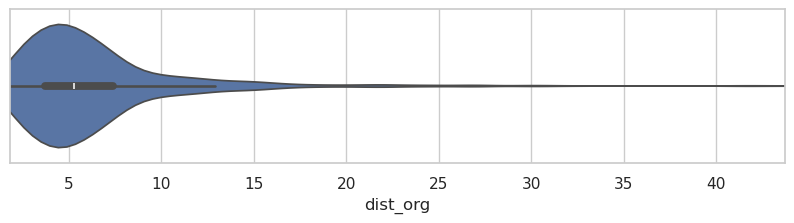

In [53]:
### Distribution de la distance chi-2

sns.set_theme(style="whitegrid",rc={"figure.figsize":(10,2)} )


a = X['dist_org']
# a = X['dist_org'][X['dist_org']< 20]

print(a.describe())

ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [54]:
### Ajouter la distance des individus à leur données
# On créé un nouveau DataFrame qui résulte de la jointure des deux précédents
cdf_mod_dist= pd.merge(cdf_mod, X.dist_org, left_index=True, right_index=True)
cdf_mod_dist[:3]

orig_index                                        uri  \
0          13  http://www.wikidata.org/entity/Q100276765   
1          18     http://www.wikidata.org/entity/Q100346   
2          22  http://www.wikidata.org/entity/Q100374862   

                                     nom genre  annee_nais  eff_occupations  \
0                 Charles-Henri Tabareau     M        1790                1   
1                  Johann Heinrich Voigt     M        1613                2   
2  Muhammad ibn Abd al-Rahman al-Afaliqi     M        1688                3   

                     liste_occup               origine_geog             o1  \
0                       Physique             France_Benelux    d1_Physique   
1       Astronomie,Mathematiques          Espace_germanique  d1_Astronomie   
2  Astronomie,Enseignant,Lettres  Moyen_Orient_Afrique_Nord  d1_Astronomie   

              a1                o2     o3   periodes  dist_org  
0          d2_nr             d3_nr  d4_nr  1751-1800    2.1856  
1          d2_nr  d3_Mathematiques  d4_nr  1601-1650    3.3567  
2  d2_Enseignant        d3_Lettres  d4_nr  1651-1700   22.1917

In [55]:
### Individus proches du profil moyen
#  donc fréquents
df_filtered = cdf_mod_dist[cdf_mod_dist.dist_org<2]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org')[:5]

34


orig_index                                       uri  \
6            99    http://www.wikidata.org/entity/Q101402   
14          322    http://www.wikidata.org/entity/Q103042   
19          410   http://www.wikidata.org/entity/Q1040068   
50          889   http://www.wikidata.org/entity/Q1079662   
783       11554  http://www.wikidata.org/entity/Q28943561   

                                      nom genre  annee_nais  eff_occupations  \
6    Friedrich Bernhard Gottfried Nicolai     M        1793                1   
14            John Parish von Senftenberg     M        1774                1   
19           Karl Philipp Heinrich Pistor     M        1778                1   
50        Christian Friedrich Scheithauer     M        1771                1   
783                      Wilhelmine Witte     F        1777                1   

    liste_occup       origine_geog             o1     a1     o2     o3  \
6    Astronomie  Espace_germanique  d1_Astronomie  d2_nr  d3_nr  d4_nr   
14   Astronomie  Espace_germanique  d1_Astronomie  d2_nr  d3_nr  d4_nr   
19   Astronomie  Espace_germanique  d1_Astronomie  d2_nr  d3_nr  d4_nr   
50   Astronomie  Espace_germanique  d1_Astronomie  d2_nr  d3_nr  d4_nr   
783  Astronomie  Espace_germanique  d1_Astronomie  d2_nr  d3_nr  d4_nr   

      periodes  dist_org  
6    1751-1800    1.8263  
14   1751-1800    1.8263  
19   1751-1800    1.8263  
50   1751-1800    1.8263  
783  1751-1800    1.8263

In [56]:
3## Inspecter les combinaisons les plus fréquentes
cdf_mod_dist.groupby(by=['periodes','origine_geog','o1','a1','o2'],\
                       observed=True).size().sort_values(ascending=False).head(10)

periodes   origine_geog       o1             a1             o2              
1751-1800  Iles_britanniques  d1_Astronomie  d2_nr          d3_nr               25
1701-1750  France_Benelux     d1_Astronomie  d2_nr          d3_nr               16
           Iles_britanniques  d1_Astronomie  d2_nr          d3_nr               15
1751-1800  Espace_germanique  d1_Astronomie  d2_nr          d3_nr               14
1651-1700  Espace_germanique  d1_Astronomie  d2_nr          d3_nr               12
1751-1800  France_Benelux     d1_Astronomie  d2_nr          d3_nr               12
1701-1750  France_Benelux     d1_Astronomie  d2_nr          d3_Mathematiques    11
1751-1800  Espace_germanique  d1_Astronomie  d2_Enseignant  d3_Mathematiques    11
           Russie             d1_Astronomie  d2_nr          d3_nr               10
1601-1650  Iles_britanniques  d1_Astrologie  d2_nr          d3_nr               10
dtype: int64

In [57]:
### Individus moyennements distants du profil moyen
df_filtered = cdf_mod_dist[(cdf_mod_dist.dist_org>4.5) & (cdf_mod_dist.dist_org <5.5)]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org')[:5]

295


orig_index                                       uri  \
379         5949   http://www.wikidata.org/entity/Q1597992   
152         3006    http://www.wikidata.org/entity/Q119739   
55           936   http://www.wikidata.org/entity/Q1081671   
63           983   http://www.wikidata.org/entity/Q1085393   
1358       18461  http://www.wikidata.org/entity/Q60080744   

                          nom genre  annee_nais  eff_occupations  \
379         Heinrich Klausing     M        1675                4   
152   Johann Georg Liebknecht     M        1679                4   
55            Christian Sahme     M        1663                4   
63       Christoph Langhansen     M        1691                4   
1358          Giuseppe Morosi     M        1772                2   

                                    liste_occup        origine_geog  \
379   Astronomie,Clerc,Enseignant,Mathematiques   Espace_germanique   
152   Astronomie,Clerc,Enseignant,Mathematiques   Espace_germanique   
55    Astronomie,Clerc,Enseignant,Mathematiques   Espace_germanique   
63    Astronomie,Clerc,Enseignant,Mathematiques   Espace_germanique   
1358                         Ingenieur,Physique  Europe_méridionale   

                 o1            a1                o2     o3   periodes  \
379   d1_Astronomie      d2_Clerc  d3_Mathematiques  d4_nr  1651-1700   
152   d1_Astronomie      d2_Clerc  d3_Mathematiques  d4_nr  1651-1700   
55    d1_Astronomie      d2_Clerc  d3_Mathematiques  d4_nr  1651-1700   
63    d1_Astronomie      d2_Clerc  d3_Mathematiques  d4_nr  1651-1700   
1358    d1_Physique  d2_Ingenieur             d3_nr  d4_nr  1751-1800   

      dist_org  
379     4.5004  
152     4.5004  
55      4.5004  
63      4.5004  
1358    4.5069

In [58]:
### Individus très distants du profil moyen
#  donc rares, triés en commençant par les plus rares
df_filtered = cdf_mod_dist[cdf_mod_dist.dist_org>15]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org', ascending=False)[:10]

76


orig_index                                       uri  \
110         2271    http://www.wikidata.org/entity/Q115466   
325         5229   http://www.wikidata.org/entity/Q1519411   
986        13044   http://www.wikidata.org/entity/Q3565952   
1143       15314  http://www.wikidata.org/entity/Q45439746   
1077       14441    http://www.wikidata.org/entity/Q423644   
1199       16096    http://www.wikidata.org/entity/Q494615   
1150       15328  http://www.wikidata.org/entity/Q45693310   
1164       15420   http://www.wikidata.org/entity/Q4664587   
1711       22635   http://www.wikidata.org/entity/Q9168741   
1160       15389    http://www.wikidata.org/entity/Q463374   

                        nom genre  annee_nais  eff_occupations  \
110        Jamshīd al-Kāshī     M        1380                4   
325       John Chortasmenos     M        1370                3   
986   Georgius Chrysococcas     M        1400                4   
1143                Hu Guan     M        1361                2   
1077             Ali Qushji     M        1403                6   
1199         Jang Yeong-sil     M        1400                3   
1150                Jin Wen     M        1370                1   
1164  Abd al-Rahman al-Fasi     M        1631                3   
1711         Benedict Makra     M        1360                3   
1160        Elijah Mizrachi     M        1450                2   

                                            liste_occup  \
110        Astrologie,Astronomie,Mathematiques,Medecine   
325                      Astronomie,Clerc,Mathematiques   
986           Astronomie,Lettres,Mathematiques,Medecine   
1143                                    Arts,Astronomie   
1077  Astrologie,Astronomie,Enseignant,Mathematiques...   
1199                     Astronomie,Chercheur,Ingenieur   
1150                                         Astronomie   
1164                                Arts,Astronomie,SHS   
1711             Astronomie,Philosophie,Politique_droit   
1160                           Astronomie,Mathematiques   

                   origine_geog             o1                  a1  \
110   Moyen_Orient_Afrique_Nord  d1_Astrologie               d2_nr   
325   Moyen_Orient_Afrique_Nord  d1_Astronomie            d2_Clerc   
986   Moyen_Orient_Afrique_Nord  d1_Astronomie               d2_nr   
1143       Asie_orientale_Chine  d1_Astronomie               d2_nr   
1077  Moyen_Orient_Afrique_Nord  d1_Astrologie       d2_Enseignant   
1199       Asie_orientale_Chine  d1_Astronomie        d2_Ingenieur   
1150       Asie_orientale_Chine  d1_Astronomie               d2_nr   
1164  Moyen_Orient_Afrique_Nord  d1_Astronomie               d2_nr   
1711            Europe_centrale  d1_Astronomie  d2_Politique_droit   
1160  Moyen_Orient_Afrique_Nord  d1_Astronomie               d2_nr   

                    o2                o3   periodes  dist_org  
110        d3_Medecine  d4_Mathematiques  1351-1400   43.7038  
325   d3_Mathematiques             d4_nr  1351-1400   42.2918  
986        d3_Medecine        d4_Lettres  1351-1400   41.6392  
1143           d3_Arts             d4_nr  1351-1400   40.9076  
1077            d3_SHS  d4_Mathematiques  1401-1450   35.8268  
1199             d3_nr             d4_nr  1351-1400   32.4147  
1150             d3_nr             d4_nr  1351-1400   31.0749  
1164           d3_Arts            d4_SHS  1601-1650   30.1261  
1711    d3_Philosophie             d4_nr  1351-1400   30.0966  
1160  d3_Mathematiques             d4_nr  1401-1450   30.0212

### Inspection des modalités des variables

In [59]:
### Profil moyen colonnes
moda_moy = np.ones(X.shape[0])/n
moda_moy[:10]


array([0.00056022, 0.00056022, 0.00056022, 0.00056022, 0.00056022,
       0.00056022, 0.00056022, 0.00056022, 0.00056022, 0.00056022])

In [60]:
# enelver la colonne 'dist-org'
df = X.iloc[:,:-1]
# somme en colonne
somme_col = np.sum(df.values,axis=0)
print(somme_col)
# poids des variables_modalités (points modalités)
poids_moda = somme_col/(n*p)
# distance au chi-2 de la valeur moyenne
disto_moda = np.apply_along_axis(arr=df.values/somme_col,axis=0,func1d=lambda x:
np.sum(n*(x-moda_moy)**2))
#np
inertie_moda = poids_moda * disto_moda
#affichage
dfc = pd.DataFrame(np.transpose([poids_moda,disto_moda,inertie_moda]),index=df.columns,columns=['Poids','Disto','Inertie'])


### La disposition des lignes est en fonction des modalités, 
# et la somme des colonnes a été transposée pour avoir des lignes

### Noter que les modalités rares apportent beaucoup de variation
# mais que leur valeur est pondérée en la multipliant par leur (petite) fréquence (=poids)
dfc

[  16   31   75  106  166  180  216  444  551   35   43  497  111  196
  425  283   20   67  108  148 1027  610  142  186  330  200  125  802
   34  156  158  414  212  151   35   90  535]


Poids       Disto   Inertie
1351-1400                  0.001793  110.562500  0.198207
1401-1450                  0.003473   56.580645  0.196527
1451-1500                  0.008403   22.800000  0.191597
1501-1550                  0.011877   15.839623  0.188123
1551-1600                  0.018599    9.753012  0.181401
1601-1650                  0.020168    8.916667  0.179832
1651-1700                  0.024202    7.263889  0.175798
1701-1750                  0.049748    3.020270  0.150252
1751-1800                  0.061737    2.239564  0.138263
Amérique_nord              0.003922   50.000000  0.196078
Asie_orientale_Chine       0.004818   40.511628  0.195182
Espace_germanique          0.055686    2.591549  0.144314
Europe_centrale            0.012437   15.081081  0.187563
Europe_méridionale         0.021961    8.107143  0.178039
France_Benelux             0.047619    3.200000  0.152381
Iles_britanniques          0.031709    5.307420  0.168291
Moyen_Orient_Afrique_Nord  0.002241   88.250000  0.197759
Russie                     0.007507   25.641791  0.192493
Scandinavie                0.012101   15.527778  0.187899
d1_Astrologie              0.016583   11.060811  0.183417
d1_Astronomie              0.115070    0.738072  0.084930
d1_Physique                0.068347    1.926230  0.131653
d2_Chercheur               0.015910   11.570423  0.184090
d2_Clerc                   0.020840    8.596774  0.179160
d2_Enseignant              0.036975    4.409091  0.163025
d2_Ingenieur               0.022409    7.925000  0.177591
d2_Politique_droit         0.014006   13.280000  0.185994
d2_nr                      0.089860    1.225686  0.110140
d3_Arts                    0.003810   51.500000  0.196190
d3_Autres_sciences         0.017479   10.442308  0.182521
d3_Lettres                 0.017703   10.297468  0.182297
d3_Mathematiques           0.046387    3.311594  0.153613
d3_Medecine                0.023754    7.419811  0.176246
d3_Philosophie             0.016919   10.821192  0.183081
d3_Physique                0.003922   50.000000  0.196078
d3_SHS                     0.010084   18.833333  0.189916
d3_nr                      0.059944    2.336449  0.140056

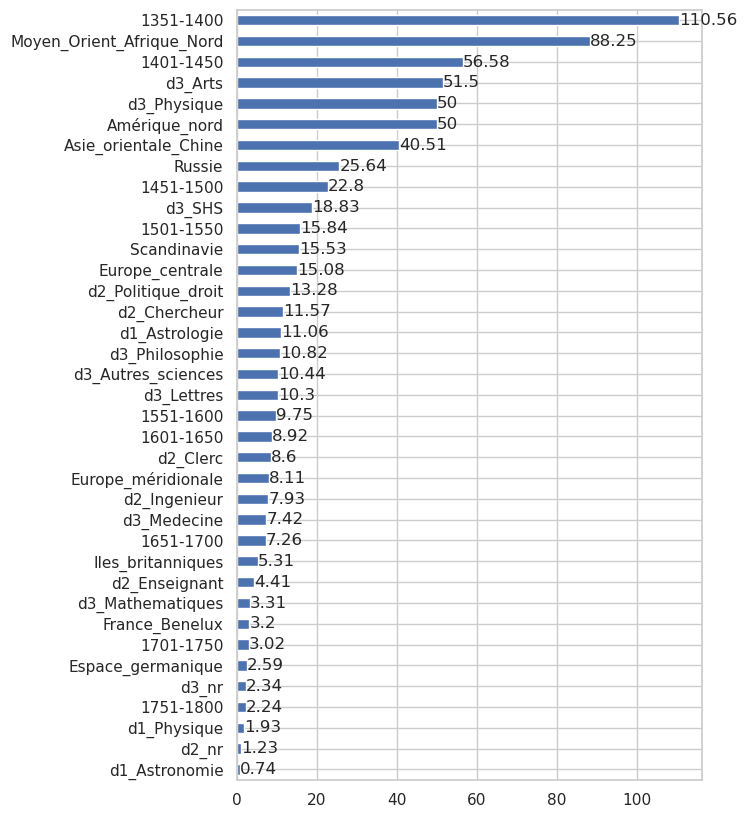

In [61]:
### distance au chi-2 de la valeur moyenne
# Les premières modalités sont celles qui sont plus rares
ax = round(dfc.Disto.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])

plt.show()

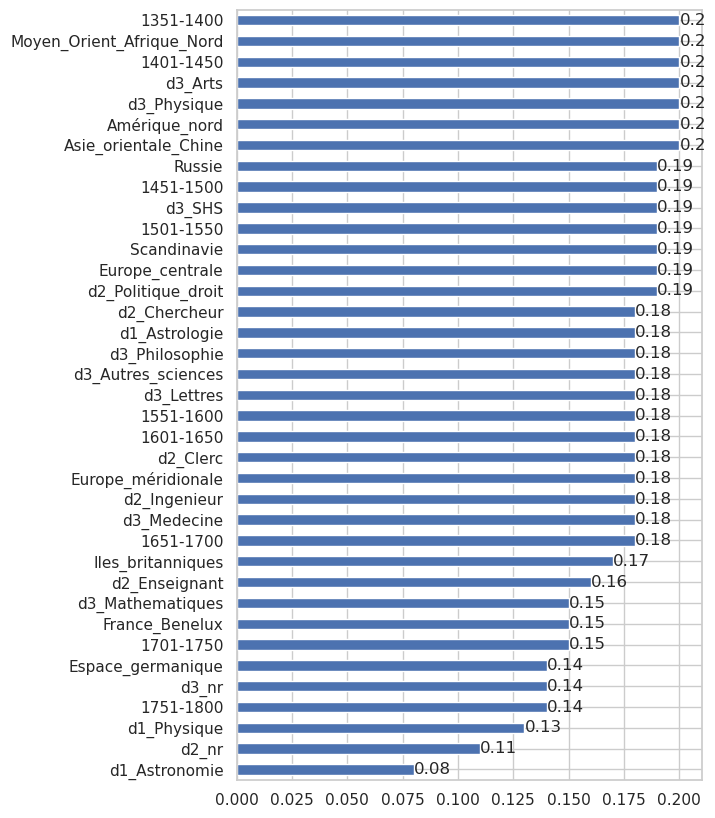

In [62]:
### Inertie, i.e. contribution à la variance
ax = round(dfc.Inertie.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])

plt.show()

### Représentation graphique

In [63]:
acm = MCA(row_labels=DActives.index,var_labels=DActives.columns)
acm.fit(DActives.values)

MCA(row_labels=RangeIndex(start=0, stop=1785, step=1),
    var_labels=Index(['periodes', 'origine_geog', 'o1', 'a1', 'o2'], dtype='object'))

In [64]:
eig = pd.DataFrame(acm.eig_).transpose()
eig.columns=['contribution','freq','freq_cumulee']

eig.head(), eig.tail()


(   contribution      freq  freq_cumulee
 0      0.360768  5.637006      5.637006
 1      0.315029  4.922327     10.559333
 2      0.278300  4.348434     14.907766
 3      0.263620  4.119056     19.026823
 4      0.251038  3.922474     22.949297,
     contribution      freq  freq_cumulee
 27      0.136875  2.138667     92.800695
 28      0.135083  2.110678     94.911372
 29      0.119714  1.870537     96.781909
 30      0.117439  1.834983     98.616892
 31      0.088519  1.383108    100.000000)

In [65]:
### Nombre total de modalités, toute variable confondue
M = X.shape[1]
print('Nombre de modalités:', M)
#nombre max de facteurs
Hmax = M-p
print('Nombre maximal de facteurs:', Hmax)

Nombre de modalités: 38
Nombre maximal de facteurs: 33


In [66]:
### nombre de facteurs calculés par la librairie
print(len(acm.eig_[0]))
### Fréquence cumulée
#acm.eig_[2]

32


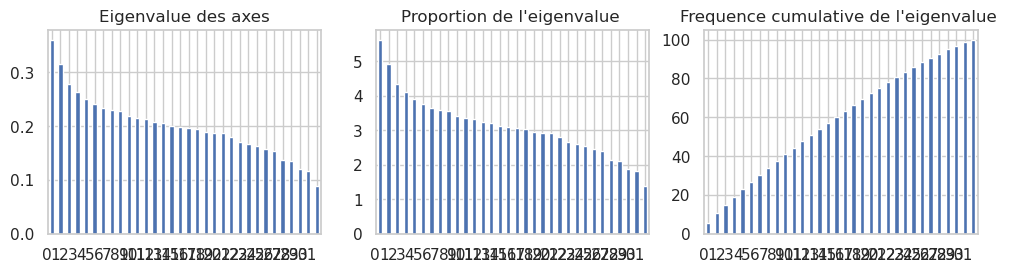

In [67]:
# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

eig.iloc[:,0].plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
eig.iloc[:,1].plot(kind='bar', ax=axes[1], title="Proportion de l'eigenvalue ")
eig.iloc[:,2].plot(kind='bar', ax=axes[2], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

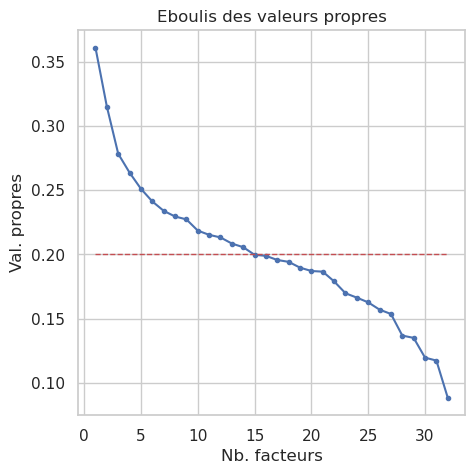

In [68]:
#éboulis des v.p.

xvalues = len(acm.eig_[0])+1

fix,ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,xvalues),acm.eig_[0],".-")
ax.set_xlabel("Nb. facteurs")
ax.set_ylabel("Val. propres")
plt.title("Eboulis des valeurs propres")
#seuil - Règle de Kaiser
ax.plot([1,xvalues-1],[1/p,1/p],"r--",linewidth=1)
plt.show()

In [69]:
### Correction de Benzecri, cf. Rakotomalala, Pratique, p.313sqq

#somme en colonne
#récupérer les valeurs propres supérieur à (1/p)
lambada = acm.eig_[0][acm.eig_[0]>1/p]
#print(lambada)

#appliquer la correction
lambada_prim = ((p/(p-1))*(lambada-1/p))**2
#print(lambada_prim)

#faire la somme
S_prim = np.sum(lambada_prim)
#print('u',S_prim)

#et produire les pourcentages
percent_prim = lambada_prim/S_prim*100

#affichage
bzc = pd.DataFrame(np.transpose(np.array([lambada_prim,percent_prim,
                                np.cumsum(percent_prim)])),columns=['Val.P','freq','Cumul_freq'],
                                index=range(1,len(percent_prim)+1))
print(bzc)

       Val.P       freq  Cumul_freq
1   0.040385  45.202033   45.202033
2   0.020674  23.140401   68.342433
3   0.009579  10.722041   79.064474
4   0.006324   7.078454   86.142928
5   0.004070   4.555643   90.698571
6   0.002655   2.971387   93.669958
7   0.001799   2.013428   95.683387
8   0.001361   1.523188   97.206575
9   0.001161   1.299605   98.506179
10  0.000537   0.601232   99.107411
11  0.000363   0.405985   99.513396
12  0.000273   0.305946   99.819343
13  0.000112   0.125152   99.944495
14  0.000050   0.055505  100.000000


In [70]:
### Préparer un calcul dynamique des dimensions du graphique
# print(acm.col_topandas().columns)
max(acm.col_topandas().col_coord_dim1), min(acm.col_topandas().col_coord_dim1)

(1.2234782407612586, -2.2605627956599257)

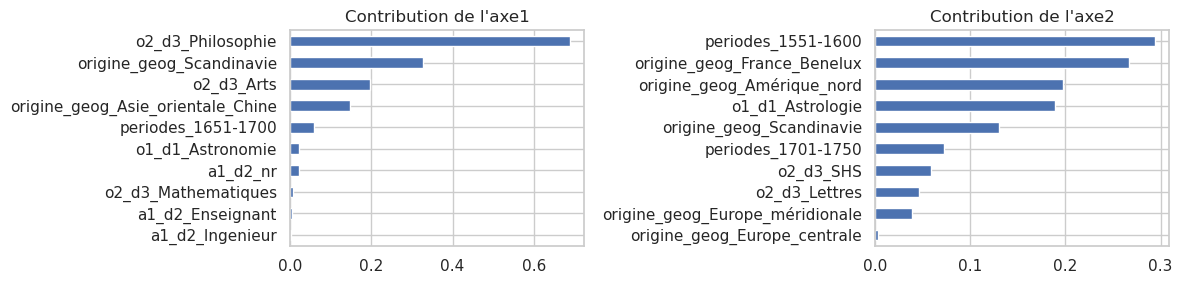

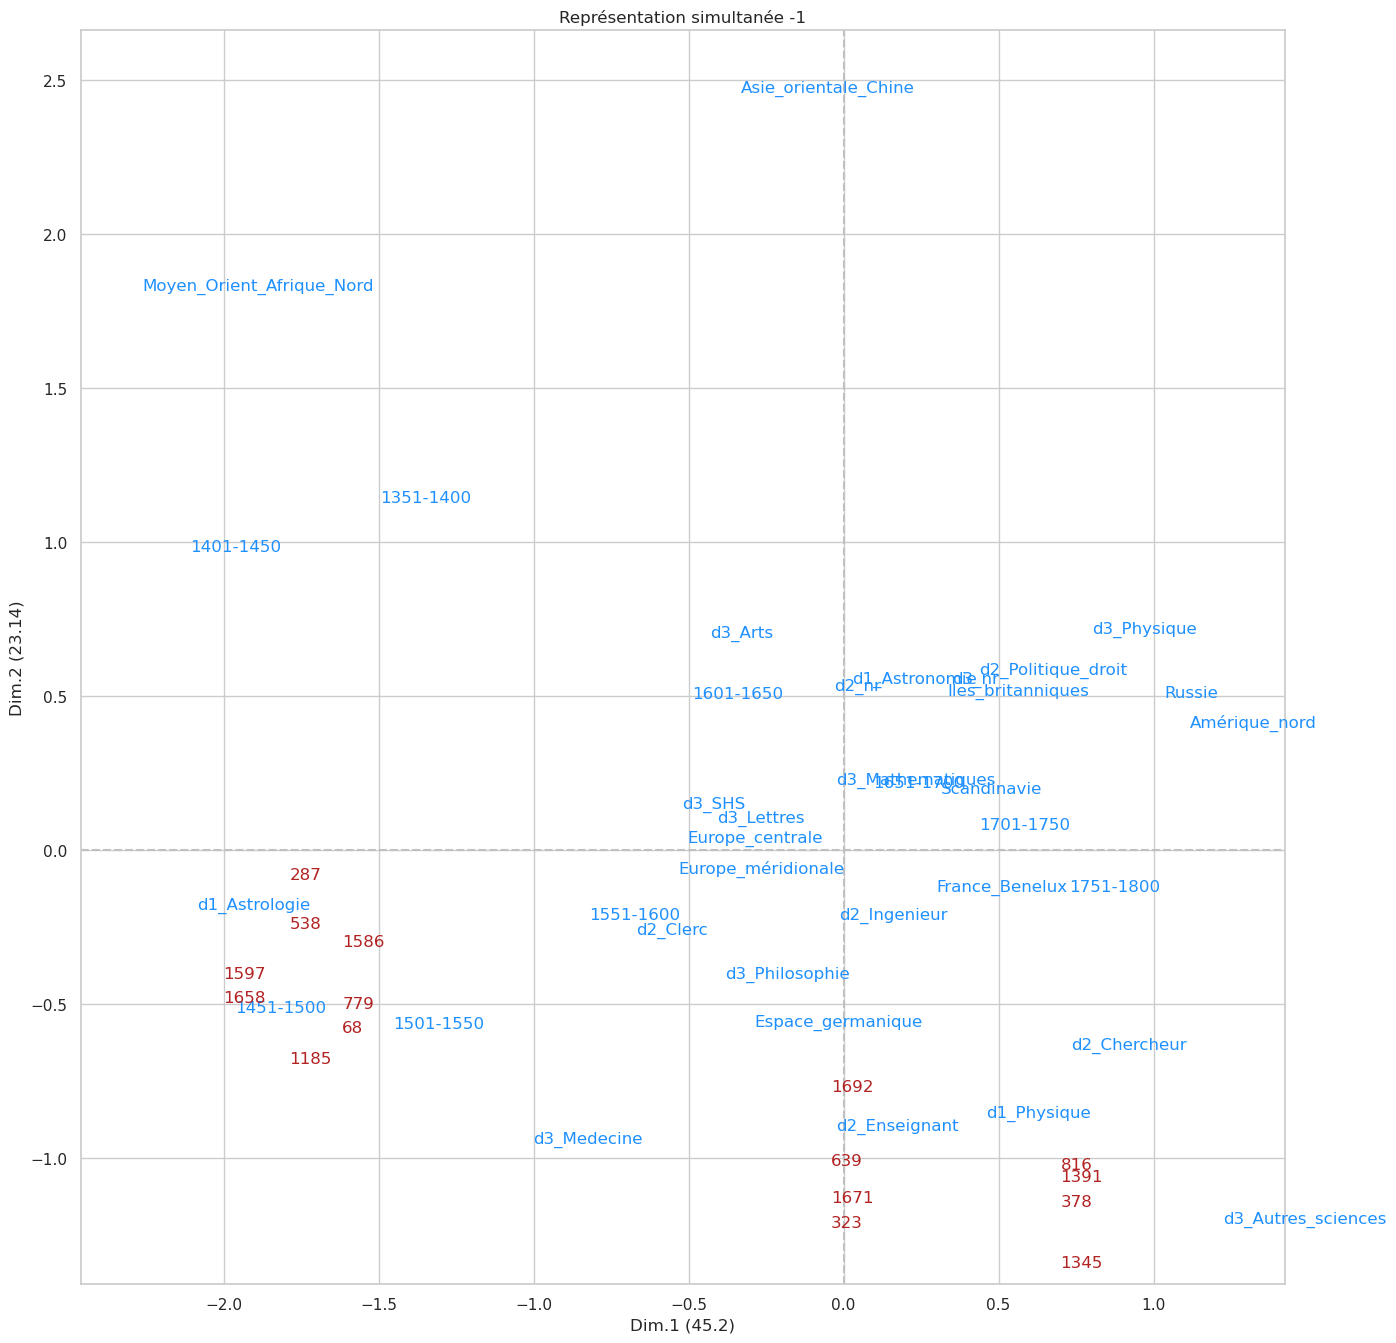

|      | periodes   | origine_geog      | o1            | a1            | o2                 |
|-----:|:-----------|:------------------|:--------------|:--------------|:-------------------|
| 1185 | 1451-1500  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
|  538 | 1451-1500  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
| 1658 | 1451-1500  | Espace_germanique | d1_Astrologie | d2_Clerc      | d3_Medecine        |
| 1597 | 1451-1500  | Espace_germanique | d1_Astrologie | d2_Clerc      | d3_Medecine        |
|  287 | 1451-1500  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
|   68 | 1501-1550  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
|  779 | 1501-1550  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
| 1586 | 1501-1550  | Espace_germanique | d1_Astrologie | d2_nr         | d3_Medecine        |
| 1345 | 1751-1800  | Espace_germanique | d1_Physi

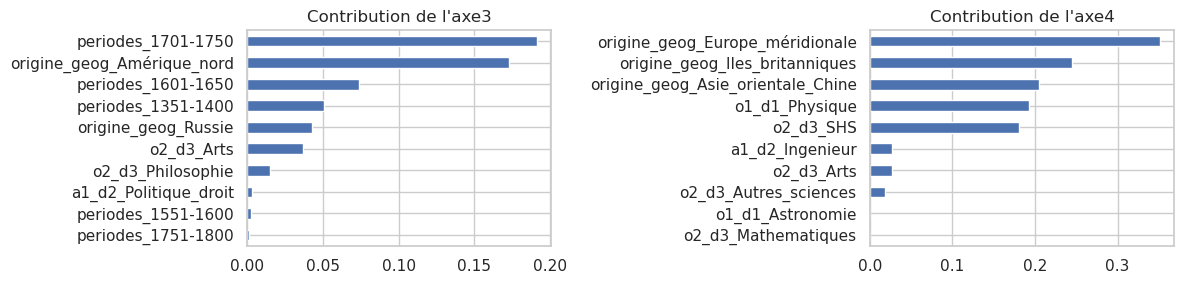

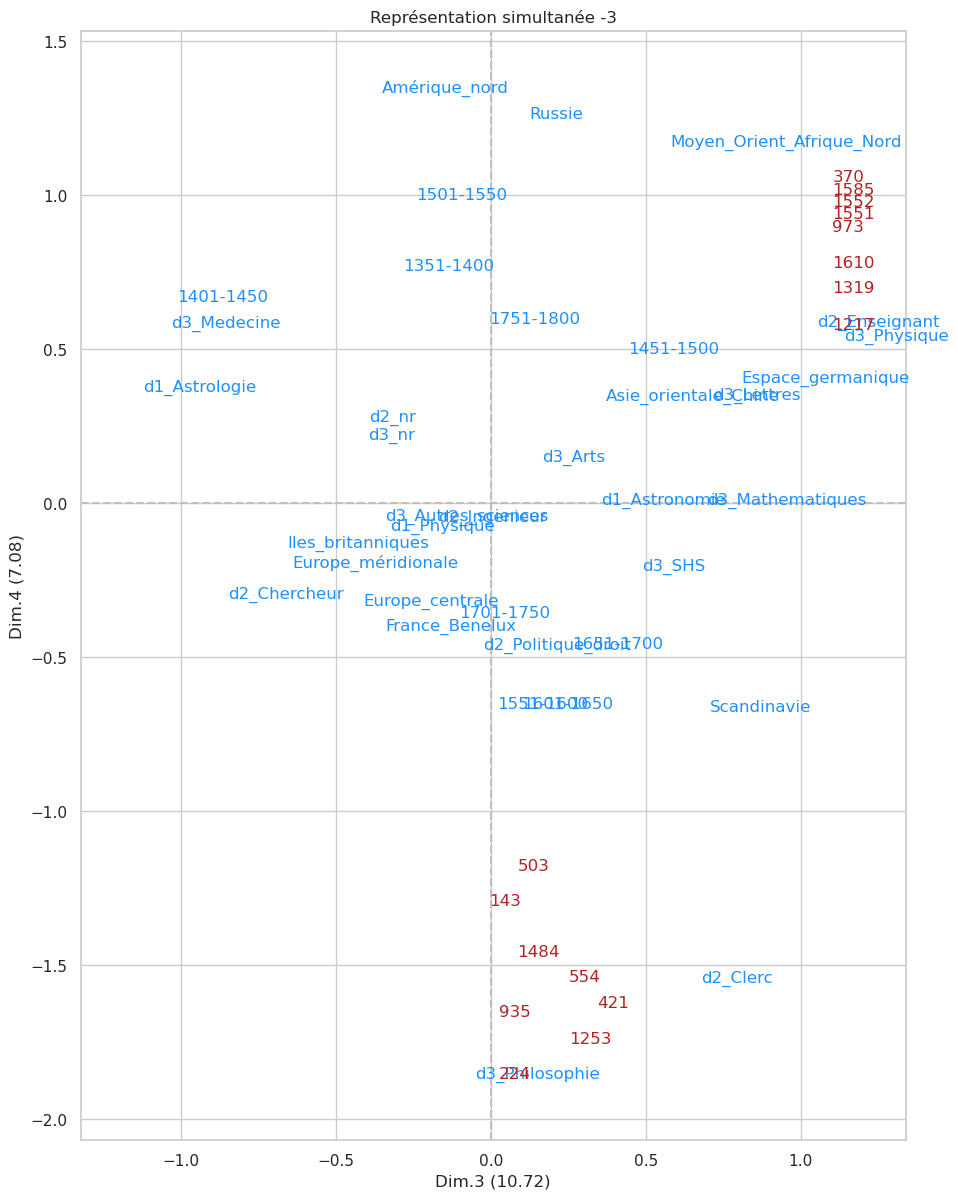

|      | periodes   | origine_geog      | o1            | a1            | o2               |
|-----:|:-----------|:------------------|:--------------|:--------------|:-----------------|
| 1253 | 1551-1600  | France_Benelux    | d1_Astronomie | d2_Clerc      | d3_Philosophie   |
|  554 | 1551-1600  | France_Benelux    | d1_Astronomie | d2_Clerc      | d3_Philosophie   |
|  143 | 1551-1600  | France_Benelux    | d1_Physique   | d2_Clerc      | d3_Philosophie   |
|  224 | 1601-1650  | France_Benelux    | d1_Physique   | d2_Clerc      | d3_Philosophie   |
|  935 | 1601-1650  | France_Benelux    | d1_Physique   | d2_Clerc      | d3_Philosophie   |
|  421 | 1651-1700  | France_Benelux    | d1_Astronomie | d2_Clerc      | d3_Philosophie   |
| 1484 | 1651-1700  | France_Benelux    | d1_Physique   | d2_Clerc      | d3_Philosophie   |
|  503 | 1651-1700  | France_Benelux    | d1_Physique   | d2_Clerc      | d3_Philosophie   |
| 1217 | 1751-1800  | Espace_germanique | d1_Astronomie | d2_Enseignan

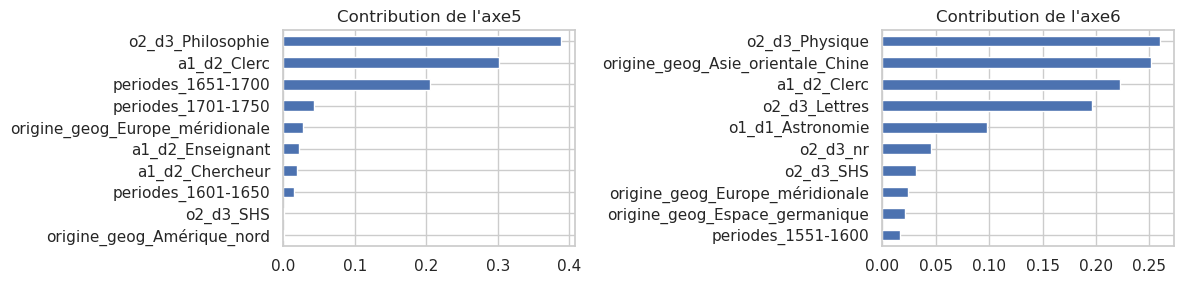

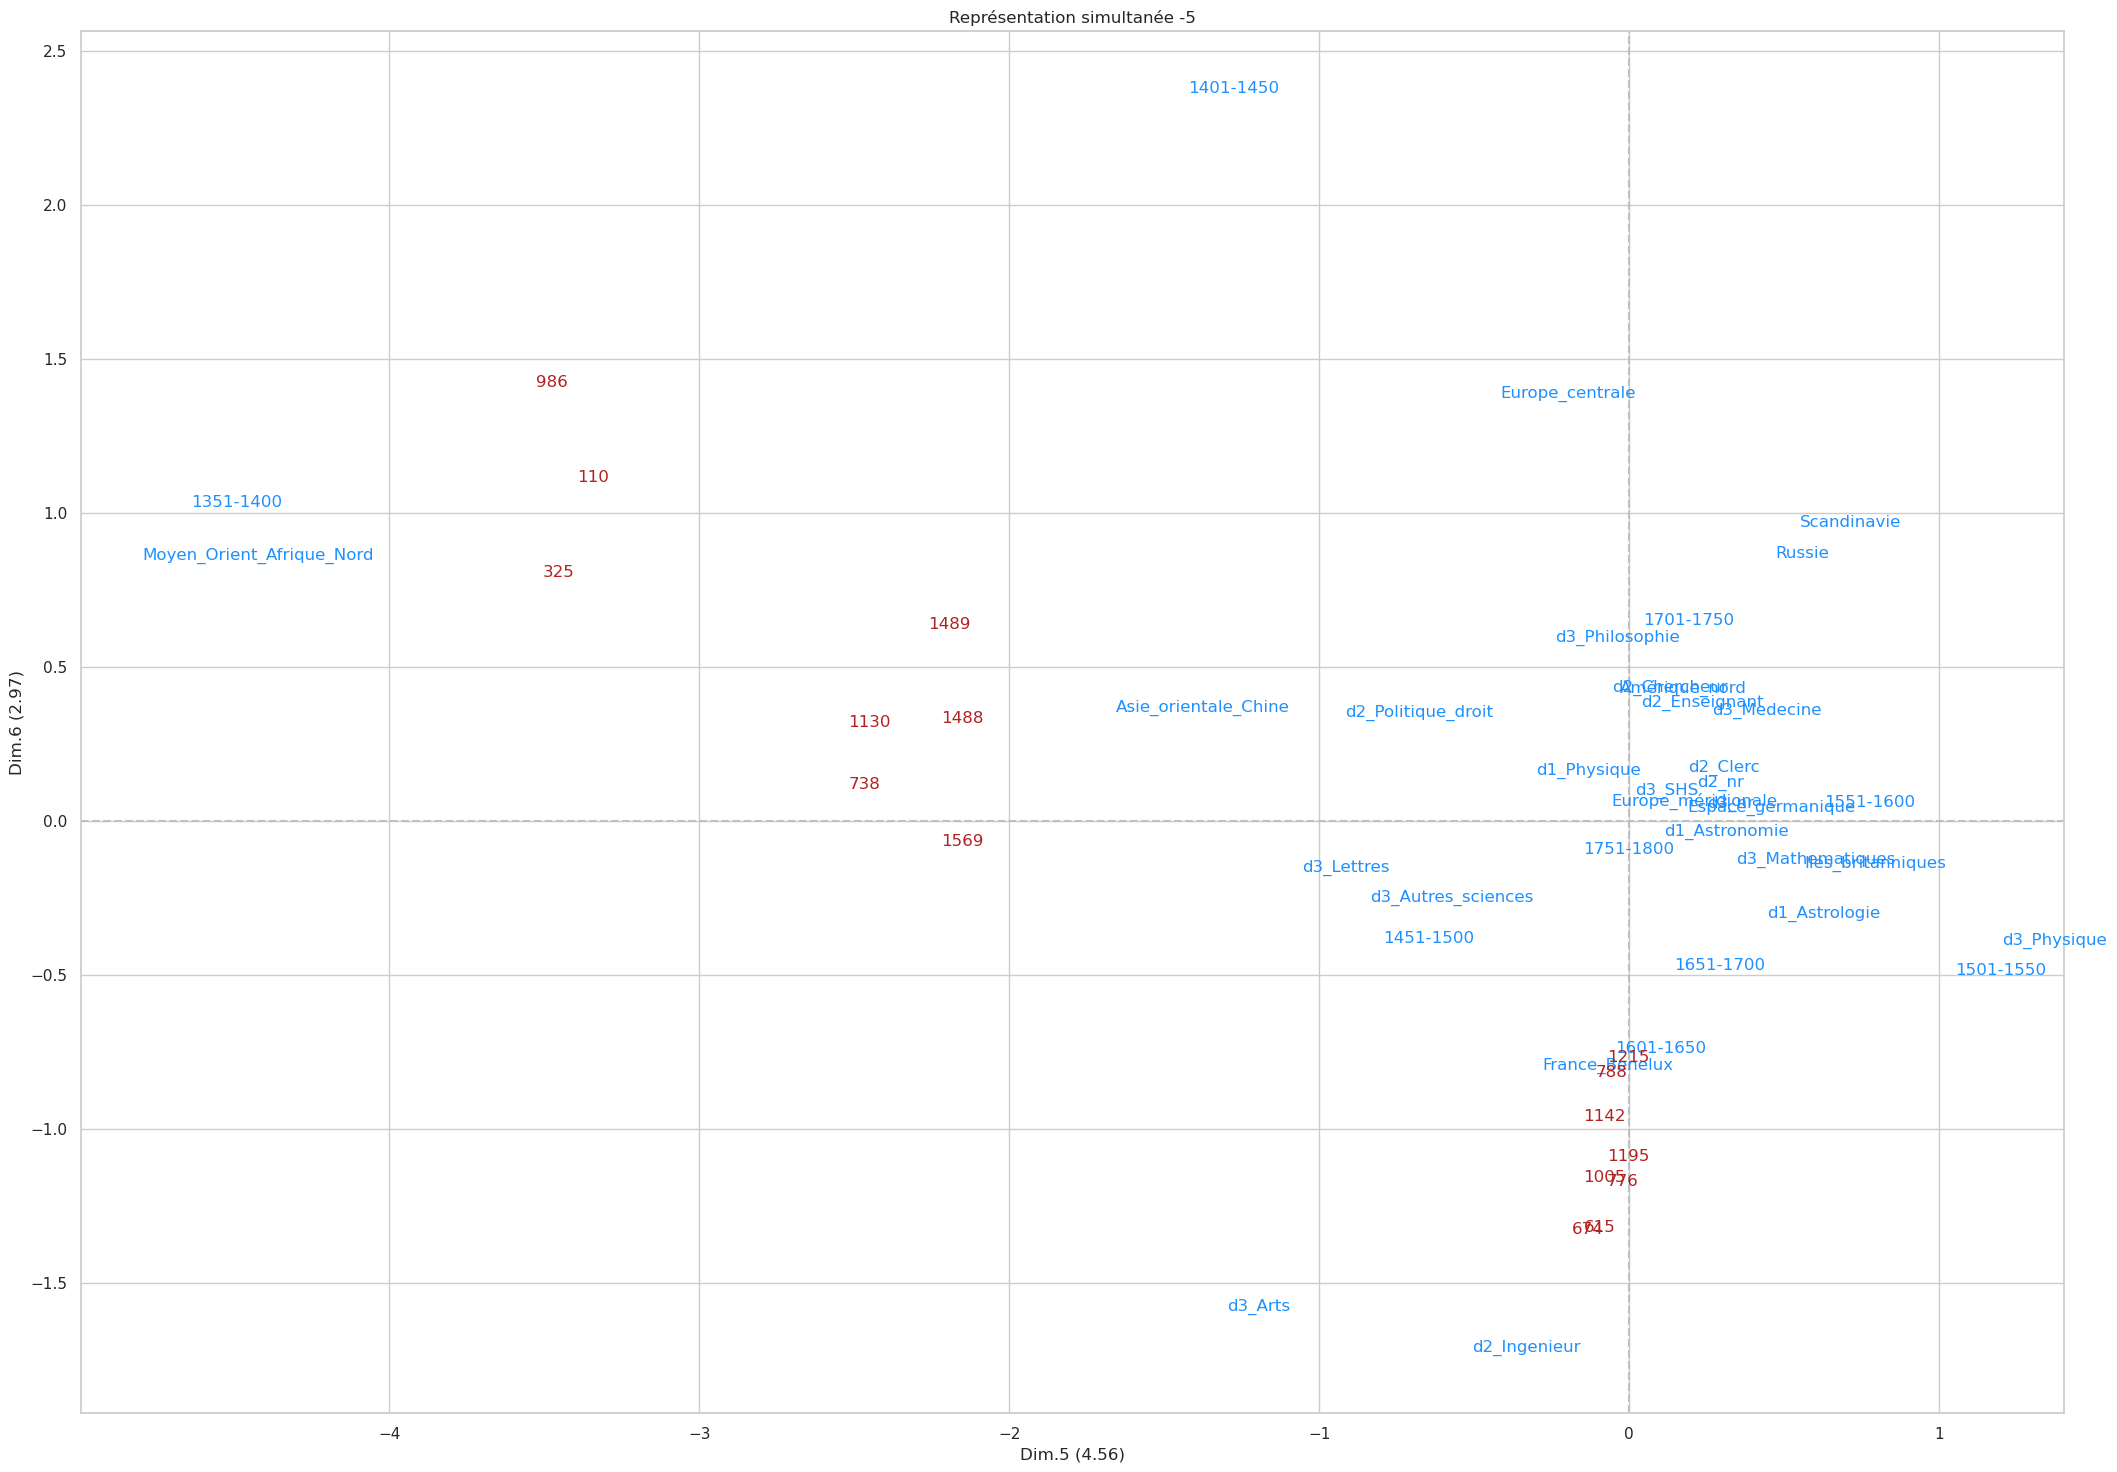

|      | periodes   | origine_geog              | o1            | a1           | o2               |
|-----:|:-----------|:--------------------------|:--------------|:-------------|:-----------------|
|  325 | 1351-1400  | Moyen_Orient_Afrique_Nord | d1_Astronomie | d2_Clerc     | d3_Mathematiques |
|  110 | 1351-1400  | Moyen_Orient_Afrique_Nord | d1_Astrologie | d2_nr        | d3_Medecine      |
|  986 | 1351-1400  | Moyen_Orient_Afrique_Nord | d1_Astronomie | d2_nr        | d3_Medecine      |
|  738 | 1451-1500  | Moyen_Orient_Afrique_Nord | d1_Astronomie | d2_nr        | d3_Lettres       |
| 1130 | 1451-1500  | Moyen_Orient_Afrique_Nord | d1_Astronomie | d2_nr        | d3_Lettres       |
| 1569 | 1601-1650  | Moyen_Orient_Afrique_Nord | d1_Astronomie | d2_nr        | d3_Lettres       |
|  674 | 1601-1650  | France_Benelux            | d1_Astronomie | d2_Ingenieur | d3_nr            |
|  615 | 1601-1650  | France_Benelux            | d1_Astronomie | d2_Ingenieur | d3_Mathematiques |


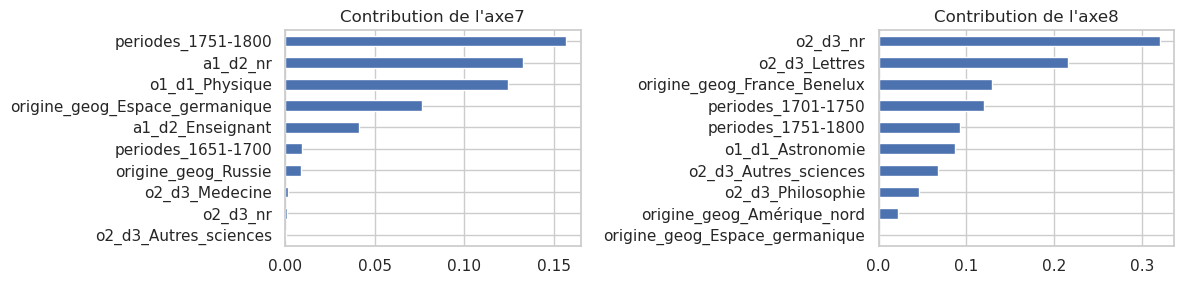

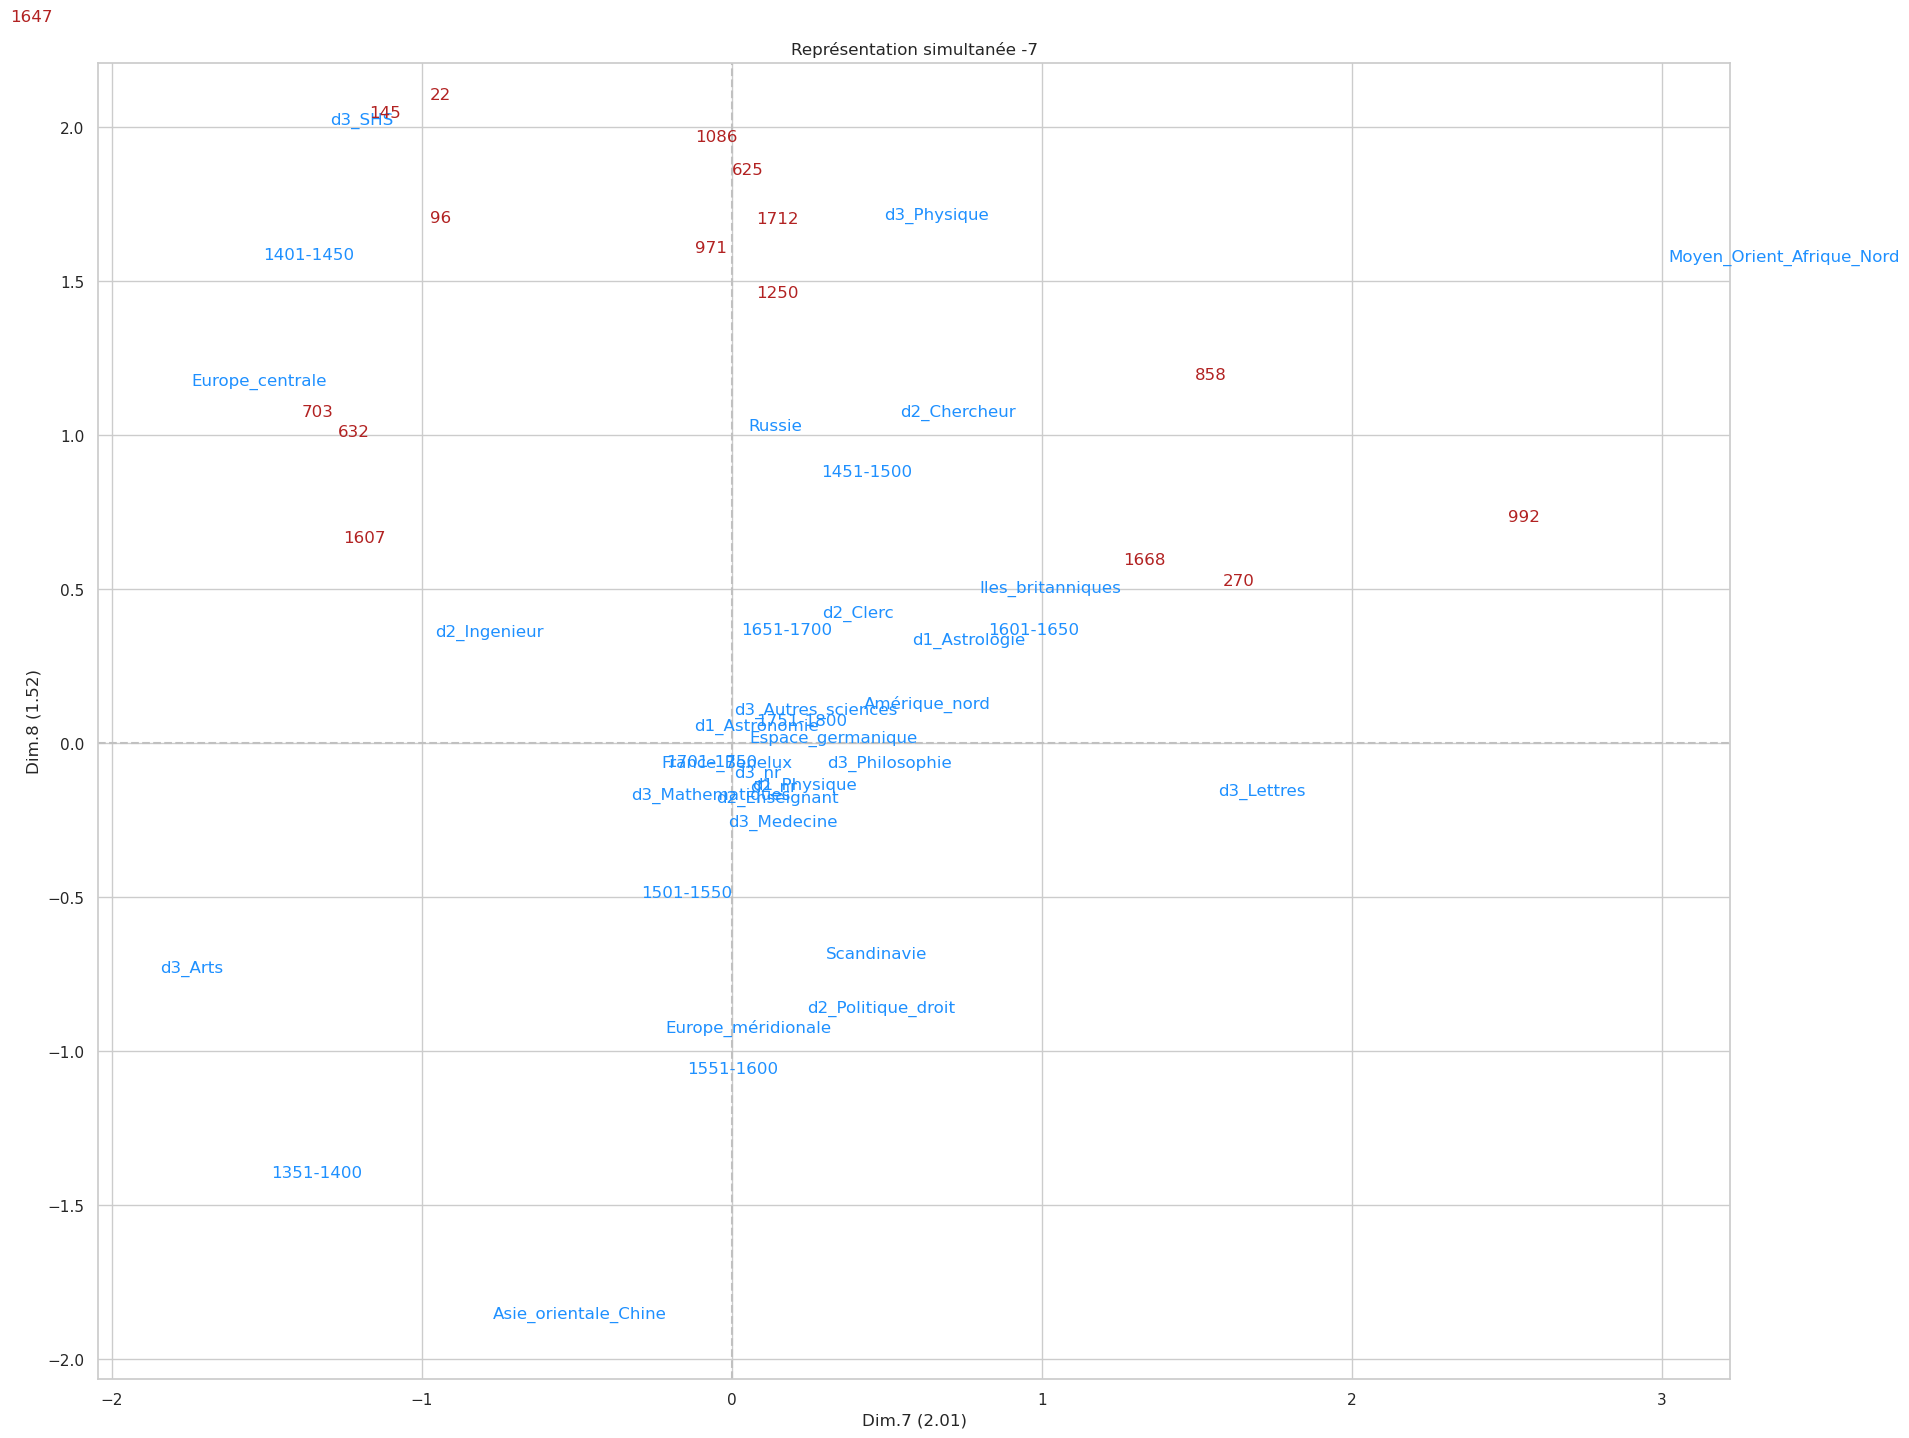

|      | periodes   | origine_geog              | o1            | a1           | o2               |
|-----:|:-----------|:--------------------------|:--------------|:-------------|:-----------------|
| 1647 | 1401-1450  | Europe_centrale           | d1_Astronomie | d2_Ingenieur | d3_SHS           |
|  992 | 1601-1650  | Moyen_Orient_Afrique_Nord | d1_Astrologie | d2_nr        | d3_Lettres       |
|  270 | 1601-1650  | Iles_britanniques         | d1_Astrologie | d2_nr        | d3_Lettres       |
|  858 | 1601-1650  | Iles_britanniques         | d1_Astronomie | d2_Chercheur | d3_Lettres       |
| 1607 | 1701-1750  | Europe_centrale           | d1_Astronomie | d2_Ingenieur | d3_nr            |
|  971 | 1701-1750  | Iles_britanniques         | d1_Astronomie | d2_Chercheur | d3_SHS           |
|  145 | 1701-1750  | Europe_centrale           | d1_Astronomie | d2_Chercheur | d3_SHS           |
| 1086 | 1701-1750  | Iles_britanniques         | d1_Astronomie | d2_Chercheur | d3_SHS           |


In [71]:
# Mapping des points colonnes

i = 1
dfc = acm.col_topandas()

df_rows = acm.row_topandas()




### avec la correction de Benzecri, 
# 3 axes apportent 95%  de l'information
while i < 8:    

    c1 = 'col_contrib_dim' + str(i)  
    c2 = 'col_contrib_dim' + str(1+i)

    #c1 = 'col_cos2_dim' + str(i)  
    #c2 = 'col_cos2_dim' + str(1+i)


    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Contribution de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Contribution de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()


    # rc1 = 'row_contrib_dim' + str(i)  
    # rc2 = 'row_contrib_dim' + str(1+i)
    rc1 = 'row_cos2_dim' + str(i)  
    rc2 = 'row_cos2_dim' + str(1+i)

    ### Filtrer les individus donnant la plus grande contribution à l'axe
    # On retient les individus les mieux représentés sur chaque axe
    rcv1 = df_rows[rc1].sort_values(ascending=False)[:8].index
    rcv2 = df_rows[rc2].sort_values(ascending=False)[:8].index

    lrc = list(set(list(rcv1) + list(rcv2)))


    min_d1 = min(dfc['col_coord_dim' + str(i)])-0.2
    max_d1 = max(dfc['col_coord_dim' + str(i)])+0.2
    min_d2 = min(dfc['col_coord_dim' + str(i+1)])-0.2
    max_d2 = max(dfc['col_coord_dim' + str(i+1)])+0.2

    #représentation simultanée
    #fig,ax = plt.subplots(figsize=(20, 20)
    fig,ax = plt.subplots(figsize=((min_d1*-1 + max_d1)*4, (min_d2*-1 + max_d2)*4))
    ax.axis([min_d1,max_d1,min_d2,max_d2])
    ax.plot([min_d1,max_d1],[0,0],color='silver',linestyle='--')
    ax.plot([0,0],[min_d2,max_d2],color='silver',linestyle='--')

    ax.set_xlabel("Dim."+str(i)+" ("+ str(round(bzc.freq.iloc[(i-1)],2))+")")
    ax.set_ylabel("Dim."+str(i+1)+" ("+ str(round(bzc.freq.iloc[i],2))+")")

    plt.title("Représentation simultanée -" + str(i))
    for i1 in range(df.shape[1]):
        ax.text(acm.col_coord_[i1,(i-1)],acm.col_coord_[i1,i],df.columns[i1],color='dodgerblue')
    
    ### espacer légèrement les individus
    a = -0.08
    for i2 in lrc:
        ax.text(acm.row_coord_[i2,(i-1)],acm.row_coord_[i2,i]+ a,df.index[i2],color='firebrick')        
        a += 0.04
    plt.show()

    print(DActives.iloc[lrc].sort_values(by='periodes').to_markdown())

    i += 2

## MCA de la période après 1801

On commence par inspecter la fréquence des modalités et on exclut les moins fréquentes

In [72]:
cdf_og = cdf_p[cdf_p.annee_nais > 1800].groupby(by='origine_geog', observed=True).size().sort_values(ascending=False)
cdf_og

origine_geog
Amérique_nord                3910
Espace_germanique            3448
Russie                       2443
Europe_centrale              2280
France_Benelux               1915
Europe_méridionale           1671
Iles_britanniques            1282
Scandinavie                  1197
Asie_orientale_Chine         1181
Asie_méridionale_Inde         651
Moyen_Orient_Afrique_Nord     479
Amérique_latine               452
Balkans                       295
Afrique_subsaharienne          57
dtype: int64

In [73]:
## exclure les modalités moins fréquentes
# Les Balkans impactaient beaucoup l'ACM ci-dessous, donc enlevés

l_og = cdf_og.index.to_list()[:-2]
print(l_og)

['Amérique_nord', 'Espace_germanique', 'Russie', 'Europe_centrale', 'France_Benelux', 'Europe_méridionale', 'Iles_britanniques', 'Scandinavie', 'Asie_orientale_Chine', 'Asie_méridionale_Inde', 'Moyen_Orient_Afrique_Nord', 'Amérique_latine']


In [74]:
### On notera l'effectif trop important des individus pour lesquels cette variable
# n'est pas renseignée. Mieux vaudra ne pas l'utiliser
cdf_p[cdf_p.annee_nais > 1800].groupby(by='o3').size().sort_values(ascending=False)

o3
d4_nr                  20369
d4_Mathematiques         266
d4_Autres_sciences       184
d4_Physique              158
d4_SHS                   113
d4_Lettres                85
d4_Arts                   73
d4_Pharmacie_chimie        8
d4_Philosophie             4
d4_Astronomie              1
dtype: int64

In [75]:
### On procède ici à l'inverse et on retient seulement les individus codés
# à l'eclusion des très faibles effectifs 
df_d3 = cdf_p[cdf_p.annee_nais > 1800].groupby(by='o2').size().sort_values(ascending=False)
df_d3

o2
d3_nr                  16354
d3_Autres_sciences      1145
d3_Lettres              1078
d3_Mathematiques        1066
d3_Physique              663
d3_SHS                   330
d3_Philosophie           223
d3_Arts                  213
d3_Medecine              151
d3_Pharmacie_chimie       37
d3_Astronomie              1
dtype: int64

In [76]:
## exclure les modalités moins fréquentes
l_d3 = df_d3.index.to_list()[1:-1]
print(l_d3)

['d3_Autres_sciences', 'd3_Lettres', 'd3_Mathematiques', 'd3_Physique', 'd3_SHS', 'd3_Philosophie', 'd3_Arts', 'd3_Medecine', 'd3_Pharmacie_chimie']


In [77]:
### On agit ici à l'inverse et on retient seulement les individus codés
df_d2 = cdf_p[cdf_p.annee_nais > 1800].groupby(by='a1').size().sort_values(ascending=False)
df_d2

a1
d2_nr                 12419
d2_Enseignant          5376
d2_Chercheur           1293
d2_Ingenieur           1292
d2_Politique_droit      674
d2_Economie             107
d2_Clerc                100
dtype: int64

In [78]:
## exclure les modalités moins fréquentes
l_d2 = df_d2.index.to_list()[1:-1]
print(l_d2)

['d2_Enseignant', 'd2_Chercheur', 'd2_Ingenieur', 'd2_Politique_droit', 'd2_Economie']


In [79]:
cdf_p[cdf_p.annee_nais < 1801].groupby(by='o1').size().sort_values(ascending=False)

o1
d1_Astronomie    1043
d1_Physique       618
d1_Astrologie     166
dtype: int64

### Préparer le tableau à analyser

Il est nécessaire de recoder le tableau pour ne pas avoir des variables avec modalités vides: on utilise donc un nouveau tableau avec les individus nés après 1800.


Aussi, on enlève les modalités les moins fréquentes (cf. ci-dessus). Le bon dosage dépend des questions de recherche.

In [80]:
### Créer une copie indépendante du DataFrame 
# tout en éliminant les modalités peu fréquentes 
cdf_cont = df_ll[(df_ll['annee_nais'] > 1800)\
                & (df_ll['annee_nais'] < 1976)\
                & (df_ll.origine_geog.isin(l_og))\
                & (df_ll.a1.isin(l_d2))\
                & (df_ll.o2.isin(l_d3))]\
                    .copy(deep=True).reset_index(names='orig_index')

### Noter que le nombre de personnes est réduit
# drastiquement — il faudrait analyser également l'ensemble

print(len(cdf_cont))
cdf_cont.head(3)

2490


orig_index                                        uri  \
0          15  http://www.wikidata.org/entity/Q100303169   
1          16  http://www.wikidata.org/entity/Q100328369   
2          33     http://www.wikidata.org/entity/Q100460   

                              nom genre  annee_nais  eff_occupations  \
0                  Klaus Dethloff     M        1950                3   
1  Belmiro Mendes de Castro Filho     M        1948                3   
2           August Ephraim Kramer     M        1817                3   

                           liste_occup       origine_geog           o1  \
0  Autres_sciences,Enseignant,Physique  Espace_germanique  d1_Physique   
1  Autres_sciences,Enseignant,Physique    Amérique_latine  d1_Physique   
2    Enseignant,Mathematiques,Physique  Espace_germanique  d1_Physique   

              a1                  o2     o3  
0  d2_Enseignant  d3_Autres_sciences  d4_nr  
1  d2_Enseignant  d3_Autres_sciences  d4_nr  
2  d2_Enseignant    d3_Mathematiques  d4_nr

In [81]:
max(cdf_cont.index)

2489

### Codage par période de vingt-cinq ans

In [82]:
### Année minimale et maximale dans la population
min(cdf_cont['annee_nais']), max(cdf_cont['annee_nais'])

(1801, 1975)

In [83]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1801, 1977, 25))
l_25[:5],l_25[-5:]

([1801, 1826, 1851, 1876, 1901], [1876, 1901, 1926, 1951, 1976])

In [84]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_cont['per_25'] = pd.cut(cdf_cont['annee_nais'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_cont['per_25'] = cdf_cont['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_cont.head(3)

orig_index                                        uri  \
0          15  http://www.wikidata.org/entity/Q100303169   
1          16  http://www.wikidata.org/entity/Q100328369   
2          33     http://www.wikidata.org/entity/Q100460   

                              nom genre  annee_nais  eff_occupations  \
0                  Klaus Dethloff     M        1950                3   
1  Belmiro Mendes de Castro Filho     M        1948                3   
2           August Ephraim Kramer     M        1817                3   

                           liste_occup       origine_geog           o1  \
0  Autres_sciences,Enseignant,Physique  Espace_germanique  d1_Physique   
1  Autres_sciences,Enseignant,Physique    Amérique_latine  d1_Physique   
2    Enseignant,Mathematiques,Physique  Espace_germanique  d1_Physique   

              a1                  o2     o3     per_25  
0  d2_Enseignant  d3_Autres_sciences  d4_nr  1926-1950  
1  d2_Enseignant  d3_Autres_sciences  d4_nr  1926-1950  
2  d2_Enseignant    d3_Mathematiques  d4_nr  1801-1825

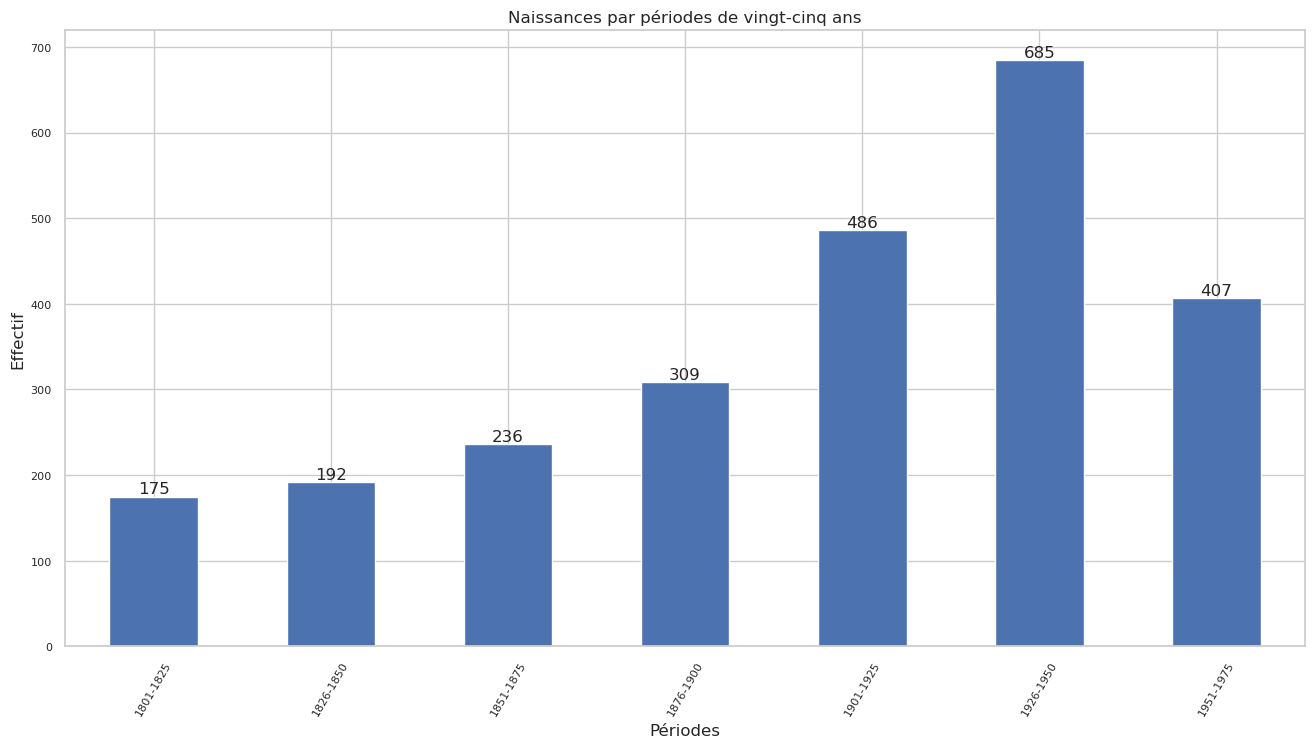

In [85]:
### compter les naissances par périodes de 25 ans
ax = cdf_cont.groupby(by='per_25', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de vingt-cinq ans')
plt.show()

### Population retenue et variables

In [86]:
DActives_ct = cdf_cont[['per_25', 'origine_geog',
 'o1', 'a1', 'o2']].copy(deep=True)

In [87]:
DActives_ct.groupby(by='origine_geog', observed=True).size().sort_values(ascending=False)


origine_geog
Espace_germanique            558
Amérique_nord                536
France_Benelux               308
Iles_britanniques            219
Europe_centrale              213
Europe_méridionale           179
Russie                       179
Scandinavie                  115
Asie_méridionale_Inde         60
Moyen_Orient_Afrique_Nord     46
Amérique_latine               43
Asie_orientale_Chine          34
dtype: int64

In [88]:
DActives_ct.groupby(by='a1', observed=True).size().sort_values(ascending=False)


a1
d2_Enseignant         1534
d2_Ingenieur           372
d2_Chercheur           364
d2_Politique_droit     190
d2_Economie             30
dtype: int64

In [89]:
DActives_ct.groupby(by='o2', observed=True).size().sort_values(ascending=False)


o2
d3_Autres_sciences     611
d3_Mathematiques       603
d3_Lettres             485
d3_Physique            307
d3_SHS                 169
d3_Philosophie         129
d3_Arts                 84
d3_Medecine             81
d3_Pharmacie_chimie     21
dtype: int64

In [90]:
#Rcupération des infos - nombre de variables
p = DActives_ct.shape[1]
#nombre d'observations
n = DActives_ct.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
#codage en 0/1
X = pd.get_dummies(DActives_ct,prefix='',prefix_sep='')*1


Nombre variables: 5 Nombre lignes: 2490


### Distance des individus par rapport au profil moyen

In [91]:
#Profil individu moyen
ind_moy = np.sum(X.values,axis=0)/(n*p)
print(ind_moy)

[0.01405622 0.01542169 0.01895582 0.02481928 0.03903614 0.05502008
 0.03269076 0.00345382 0.04305221 0.00481928 0.00273092 0.04481928
 0.01710843 0.01437751 0.02473896 0.01759036 0.00369478 0.01437751
 0.00923695 0.00192771 0.05791165 0.14016064 0.02923695 0.00240964
 0.12321285 0.02987952 0.01526104 0.00674699 0.04907631 0.03895582
 0.04843373 0.00650602 0.00168675 0.01036145 0.02465863 0.0135743 ]


In [92]:
### Ajouter une colonne avec la distance chi-2 de chaque individu par rapport à l'individu moyen
# pour chaque individu: les individus plus éloignés sont plus rares
X['dist_org'] = X.apply(lambda x: round(np.sum(1/ind_moy*(x/p-ind_moy)**2),4), raw=True, axis=1)

In [93]:
### Inspecter le tableau
X.sort_values(by='dist_org', ascending=False).head(10)['dist_org']

1575    43.9347
2398    43.6967
456     39.9176
1913    36.9289
1911    35.0518
2114    33.4098
1010    31.5572
2295    31.2486
1000    30.4261
2298    30.4010
Name: dist_org, dtype: float64

count    2490.000000
mean        6.200001
std         4.756808
min         2.044600
25%         3.591300
50%         4.809200
75%         6.823100
max        43.934700
Name: dist_org, dtype: float64


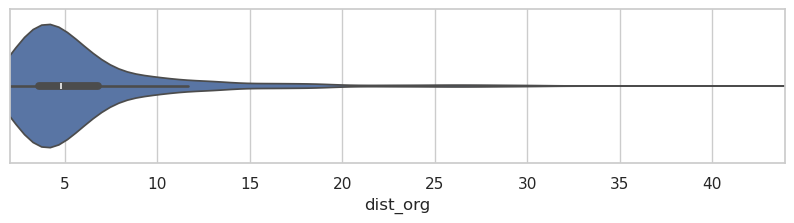

In [94]:
### Distribution de la distance chi-2

sns.set_theme(style="whitegrid",rc={"figure.figsize":(10,2)} )


a = X['dist_org']
#a = X['dist_org'][X['dist_org']< 15]

print(a.describe())

ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [95]:
### Ajouter la distance des individus à leur données
cdf_cont_dist= pd.merge(cdf_cont, X.dist_org, left_index=True, right_index=True)
cdf_cont_dist[:3]

orig_index                                        uri  \
0          15  http://www.wikidata.org/entity/Q100303169   
1          16  http://www.wikidata.org/entity/Q100328369   
2          33     http://www.wikidata.org/entity/Q100460   

                              nom genre  annee_nais  eff_occupations  \
0                  Klaus Dethloff     M        1950                3   
1  Belmiro Mendes de Castro Filho     M        1948                3   
2           August Ephraim Kramer     M        1817                3   

                           liste_occup       origine_geog           o1  \
0  Autres_sciences,Enseignant,Physique  Espace_germanique  d1_Physique   
1  Autres_sciences,Enseignant,Physique    Amérique_latine  d1_Physique   
2    Enseignant,Mathematiques,Physique  Espace_germanique  d1_Physique   

              a1                  o2     o3     per_25  dist_org  
0  d2_Enseignant  d3_Autres_sciences  d4_nr  1926-1950    2.0446  
1  d2_Enseignant  d3_Autres_sciences  d4_nr  1926-1950   12.7335  
2  d2_Enseignant    d3_Mathematiques  d4_nr  1801-1825    4.1741

In [96]:
### Individus proches du profil moyen
#  donc fréquents
df_filtered = cdf_cont_dist[cdf_cont_dist.dist_org<2.2]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org')[:5]

91


orig_index                                        uri                nom  \
0            15  http://www.wikidata.org/entity/Q100303169     Klaus Dethloff   
332        3747    http://www.wikidata.org/entity/Q1243966      Peter Paufler   
485        4976   http://www.wikidata.org/entity/Q14813432  Heinrich Reichert   
368        4193    http://www.wikidata.org/entity/Q1296873       Peter Fabian   
589        5842    http://www.wikidata.org/entity/Q1587433      Hartmut Graßl   

    genre  annee_nais  eff_occupations                          liste_occup  \
0       M        1950                3  Autres_sciences,Enseignant,Physique   
332     M        1940                3  Autres_sciences,Enseignant,Physique   
485     M        1949                3  Autres_sciences,Enseignant,Physique   
368     M        1937                3  Autres_sciences,Enseignant,Physique   
589     M        1940                3  Autres_sciences,Enseignant,Physique   

          origine_geog           o1             a1                  o2     o3  \
0    Espace_germanique  d1_Physique  d2_Enseignant  d3_Autres_sciences  d4_nr   
332  Espace_germanique  d1_Physique  d2_Enseignant  d3_Autres_sciences  d4_nr   
485  Espace_germanique  d1_Physique  d2_Enseignant  d3_Autres_sciences  d4_nr   
368  Espace_germanique  d1_Physique  d2_Enseignant  d3_Autres_sciences  d4_nr   
589  Espace_germanique  d1_Physique  d2_Enseignant  d3_Autres_sciences  d4_nr   

        per_25  dist_org  
0    1926-1950    2.0446  
332  1926-1950    2.0446  
485  1926-1950    2.0446  
368  1926-1950    2.0446  
589  1926-1950    2.0446

In [97]:
### Inspecter les combinaisons les plus fréquentes
cdf_cont_dist.groupby(by=['per_25','origine_geog','o1','a1','o2'],\
                       observed=True).size().sort_values(ascending=False).head(10)

per_25     origine_geog       o1             a1             o2                
1926-1950  Espace_germanique  d1_Physique    d2_Enseignant  d3_Lettres            30
           Amérique_nord      d1_Astronomie  d2_Enseignant  d3_Physique           28
                              d1_Physique    d2_Enseignant  d3_Mathematiques      27
           Espace_germanique  d1_Physique    d2_Enseignant  d3_Autres_sciences    27
1876-1900  Espace_germanique  d1_Physique    d2_Enseignant  d3_Autres_sciences    27
1901-1925  Espace_germanique  d1_Physique    d2_Enseignant  d3_Autres_sciences    23
1926-1950  Amérique_nord      d1_Physique    d2_Enseignant  d3_Autres_sciences    22
1901-1925  Amérique_nord      d1_Physique    d2_Enseignant  d3_Lettres            21
                                                            d3_Autres_sciences    19
1951-1975  Amérique_nord      d1_Astronomie  d2_Enseignant  d3_Physique           19
dtype: int64

In [98]:
### Individus moyennements distants du profil moyen
df_filtered = cdf_cont_dist[(cdf_cont_dist.dist_org>4.3) & (cdf_mod_dist.dist_org <4.9)]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org')[:5]

483


orig_index                                        uri               nom  \
216         2580     http://www.wikidata.org/entity/Q116962  Claude Nicollier   
1682       16383    http://www.wikidata.org/entity/Q5145108    Colin Franklin   
1435       13429     http://www.wikidata.org/entity/Q376909  William H. Press   
70           661  http://www.wikidata.org/entity/Q106299612   Didier Chatenay   
1462       13817   http://www.wikidata.org/entity/Q40312529    Claude Verdier   

     genre  annee_nais  eff_occupations  \
216      M        1944                4   
1682     M        1927                3   
1435     M        1948                4   
70       M        1955                3   
1462     M        1962                4   

                                           liste_occup       origine_geog  \
216   Activites_diverses,Astronomie,Chercheur,Physique  Espace_germanique   
1682                     Astronomie,Ingenieur,Physique      Amérique_nord   
1435          Astronomie,Enseignant,Ingenieur,Physique      Amérique_nord   
70                  Autres_sciences,Chercheur,Physique     France_Benelux   
1462     Autres_sciences,Chercheur,Enseignant,Physique     France_Benelux   

                 o1            a1                  o2     o3     per_25  \
216   d1_Astronomie  d2_Chercheur         d3_Physique  d4_nr  1926-1950   
1682  d1_Astronomie  d2_Ingenieur         d3_Physique  d4_nr  1926-1950   
1435  d1_Astronomie  d2_Ingenieur         d3_Physique  d4_nr  1926-1950   
70      d1_Physique  d2_Chercheur  d3_Autres_sciences  d4_nr  1951-1975   
1462    d1_Physique  d2_Chercheur  d3_Autres_sciences  d4_nr  1951-1975   

      dist_org  
216     4.3005  
1682    4.3077  
1435    4.3077  
70      4.3090  
1462    4.3090

In [99]:
### Individus très distants du profil moyen
#  donc rares, triés en commençant par les plus rares
df_filtered = cdf_cont_dist[cdf_cont_dist.dist_org>15]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org', ascending=False)[:10]

137


orig_index                                       uri  \
1575       15282   http://www.wikidata.org/entity/Q4532507   
2398       23019     http://www.wikidata.org/entity/Q94040   
456         4726   http://www.wikidata.org/entity/Q1399544   
1913       18806   http://www.wikidata.org/entity/Q6145086   
1911       18798     http://www.wikidata.org/entity/Q61398   
2114       20757    http://www.wikidata.org/entity/Q729048   
1010        9757    http://www.wikidata.org/entity/Q225625   
2295       22348   http://www.wikidata.org/entity/Q9011086   
1000        9657  http://www.wikidata.org/entity/Q21996854   
2298       22360   http://www.wikidata.org/entity/Q9023773   

                              nom genre  annee_nais  eff_occupations  \
1575             Michael Erlewine     M        1941                3   
2398               Guido von List     M        1848                5   
456          William Delbert Gann     M        1878                3   
1913  James Walter Chapman-Taylor     M        1878                3   
1911      Rudolf von Sebottendorf     M        1875                8   
2114            Olavo de Carvalho     M        1947                4   
1010                  Silvi Vrait     F        1951                6   
2295       Jaume Calbetó i Baralt     M        1806                3   
1000            Baikoli Mahapatra     M        1908                4   
2298               Lorenzo Presas     M        1811                4   

                                            liste_occup  \
1575                           Arts,Astrologie,Economie   
2398  Activites_diverses,Astrologie,Economie,Lettres...   
456                         Astrologie,Economie,Lettres   
1913                          Arts,Astrologie,Ingenieur   
1911  Astrologie,Astrologie,Ingenieur,Ingenieur,Lett...   
2114   Activites_diverses,Astrologie,Enseignant,Lettres   
1010  Arts,Arts,Astrologie,Astrologie,Enseignant,Ens...   
2295          Pharmacie_chimie,Physique,Politique_droit   
1000   Activites_diverses,Astrologie,Enseignant,Lettres   
2298  Astronomie,Chercheur,Mathematiques,Pharmacie_c...   

                   origine_geog             o1                  a1  \
1575              Amérique_nord  d1_Astrologie         d2_Economie   
2398          Espace_germanique  d1_Astrologie         d2_Economie   
456               Amérique_nord  d1_Astrologie         d2_Economie   
1913      Asie_méridionale_Inde  d1_Astrologie        d2_Ingenieur   
1911  Moyen_Orient_Afrique_Nord  d1_Astrologie        d2_Ingenieur   
2114            Amérique_latine  d1_Astrologie       d2_Enseignant   
1010                Scandinavie  d1_Astrologie       d2_Enseignant   
2295         Europe_méridionale    d1_Physique  d2_Politique_droit   
1000      Asie_méridionale_Inde  d1_Astrologie       d2_Enseignant   
2298         Europe_méridionale  d1_Astronomie        d2_Chercheur   

                       o2                o3     per_25  dist_org  
1575              d3_Arts             d4_nr  1926-1950   43.9347  
2398       d3_Philosophie        d4_Lettres  1826-1850   43.6967  
456            d3_Lettres             d4_nr  1876-1900   39.9176  
1913              d3_Arts             d4_nr  1876-1900   36.9289  
1911           d3_Lettres             d4_nr  1851-1875   35.0518  
2114           d3_Lettres             d4_nr  1926-1950   33.4098  
1010              d3_Arts             d4_nr  1951-1975   31.5572  
2295  d3_Pharmacie_chimie             d4_nr  1801-1825   31.2486  
1000           d3_Lettres             d4_nr  1901-1925   30.4261  
2298  d3_Pharmacie_chimie  d4_Mathematiques  1801-1825   30.4010

### Inspection des modalités des variables

C'est à ce stade qu'on vérifie le poids des modalités rares et qu'on décide éventuellement d'en enlever encore davantage, afin d'éviter qu'elle cachent la structure du champ scientifique.


Quant aux individus possédant ces modalités rares, on pourra les étudier séparément.


Rappelons que l'ACM appartient au domaine des statistiques descriptives et que pour la recherche en sciences historiques celles-ci ont une fonction heuristique, non explicative. Elles permettent toutefois de mettre en évidence des phénomènes invisibles autrement.

In [100]:
### Profil moyen colonnes
moda_moy = np.ones(X.shape[0])/n
moda_moy[:10]


array([0.00040161, 0.00040161, 0.00040161, 0.00040161, 0.00040161,
       0.00040161, 0.00040161, 0.00040161, 0.00040161, 0.00040161])

In [101]:
# enelver la colonne 'dist-org'
df = X.iloc[:,:-1]
# somme en colonne
somme_col = np.sum(df.values,axis=0)
print(somme_col)
# poids des variables_modalités (points modalités)
poids_moda = somme_col/(n*p)
# distance au chi-2 de la valeur moyenne
disto_moda = np.apply_along_axis(arr=df.values/somme_col,axis=0,func1d=lambda x:
np.sum(n*(x-moda_moy)**2))
#np
inertie_moda = poids_moda * disto_moda
#affichage
dfc = pd.DataFrame(np.transpose([poids_moda,disto_moda,inertie_moda]),index=df.columns,columns=['Poids','Disto','Inertie'])


### La disposition des lignes est en fonction des modalités, 
# et la somme des colonnes a été transposée pour avoir des lignes
dfc

[ 175  192  236  309  486  685  407   43  536   60   34  558  213  179
  308  219   46  179  115   24  721 1745  364   30 1534  372  190   84
  611  485  603   81   21  129  307  169]


Poids       Disto   Inertie
1801-1825                  0.014056   13.228571  0.185944
1826-1850                  0.015422   11.968750  0.184578
1851-1875                  0.018956    9.550847  0.181044
1876-1900                  0.024819    7.058252  0.175181
1901-1925                  0.039036    4.123457  0.160964
1926-1950                  0.055020    2.635036  0.144980
1951-1975                  0.032691    5.117936  0.167309
Amérique_latine            0.003454   56.906977  0.196546
Amérique_nord              0.043052    3.645522  0.156948
Asie_méridionale_Inde      0.004819   40.500000  0.195181
Asie_orientale_Chine       0.002731   72.235294  0.197269
Espace_germanique          0.044819    3.462366  0.155181
Europe_centrale            0.017108   10.690141  0.182892
Europe_méridionale         0.014378   12.910615  0.185622
France_Benelux             0.024739    7.084416  0.175261
Iles_britanniques          0.017590   10.369863  0.182410
Moyen_Orient_Afrique_Nord  0.003695   53.130435  0.196305
Russie                     0.014378   12.910615  0.185622
Scandinavie                0.009237   20.652174  0.190763
d1_Astrologie              0.001928  102.750000  0.198072
d1_Astronomie              0.057912    2.453537  0.142088
d1_Physique                0.140161    0.426934  0.059839
d2_Chercheur               0.029237    5.840659  0.170763
d2_Economie                0.002410   82.000000  0.197590
d2_Enseignant              0.123213    0.623207  0.076787
d2_Ingenieur               0.029880    5.693548  0.170120
d2_Politique_droit         0.015261   12.105263  0.184739
d3_Arts                    0.006747   28.642857  0.193253
d3_Autres_sciences         0.049076    3.075286  0.150924
d3_Lettres                 0.038956    4.134021  0.161044
d3_Mathematiques           0.048434    3.129353  0.151566
d3_Medecine                0.006506   29.740741  0.193494
d3_Pharmacie_chimie        0.001687  117.571429  0.198313
d3_Philosophie             0.010361   18.302326  0.189639
d3_Physique                0.024659    7.110749  0.175341
d3_SHS                     0.013574   13.733728  0.186426

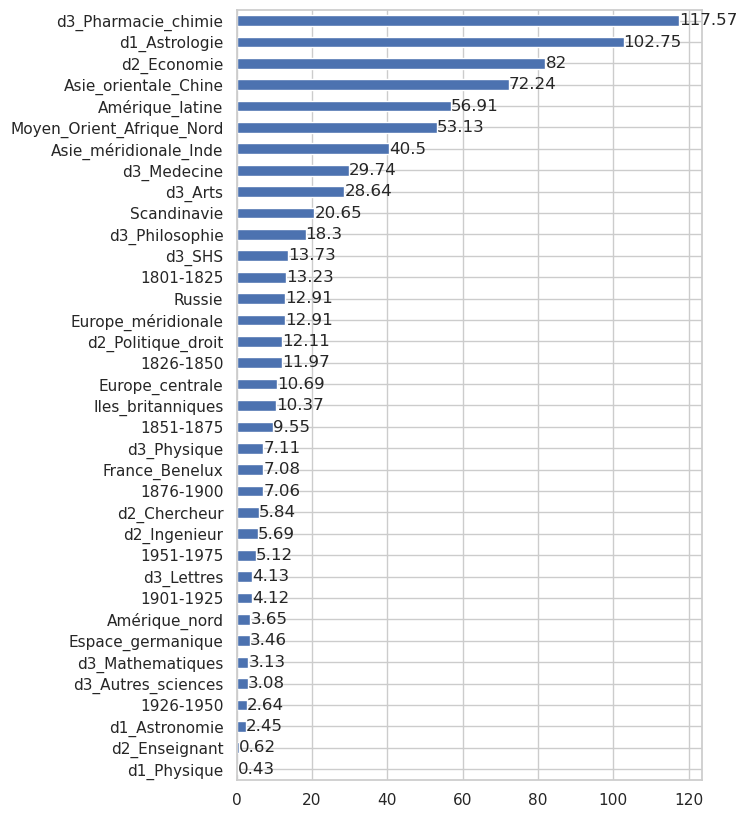

In [102]:
### distance au chi-2 de la valeur moyenne
# Les premières modalités sont celles qui sont plus rares
ax = round(dfc.Disto.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])

plt.show()

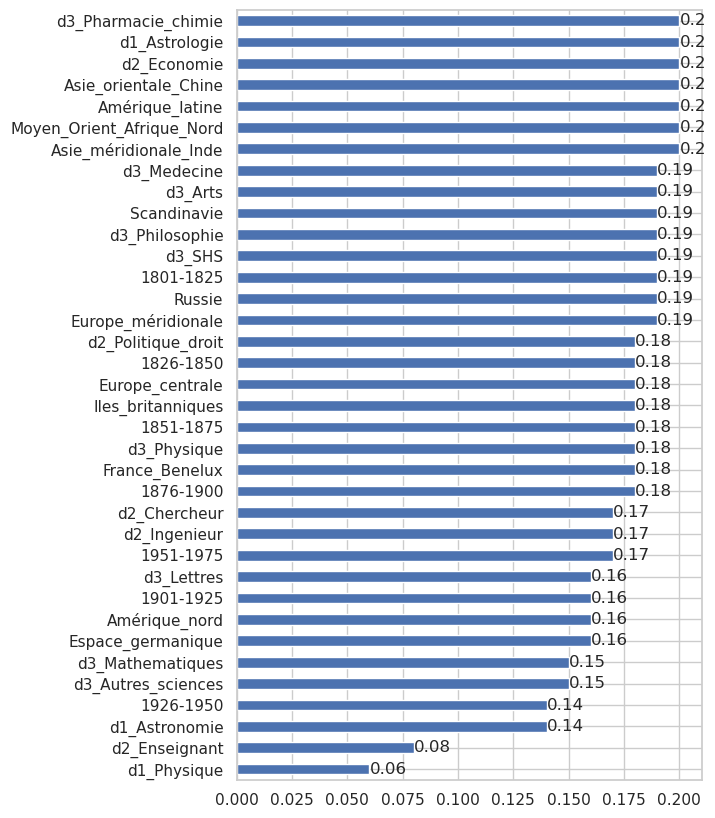

In [103]:
### Inertie, i.e. contribution à la variance
ax = round(dfc.Inertie.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])

plt.show()

### Représentation graphique

In [104]:
acm = MCA(row_labels=DActives_ct.index,var_labels=DActives_ct.columns)
acm.fit(DActives_ct.values)

MCA(row_labels=RangeIndex(start=0, stop=2490, step=1),
    var_labels=Index(['per_25', 'origine_geog', 'o1', 'a1', 'o2'], dtype='object'))

In [105]:
eig = pd.DataFrame(acm.eig_).transpose()
eig.columns=['contribution','freq','freq_cumulee']

eig.head(), eig.tail()


(   contribution      freq  freq_cumulee
 0      0.350907  5.659793      5.659793
 1      0.277185  4.470730     10.130523
 2      0.265780  4.286777     14.417300
 3      0.248085  4.001375     18.418675
 4      0.242663  3.913912     22.332587,
     contribution      freq  freq_cumulee
 26      0.156539  2.524826     92.017630
 27      0.153788  2.480445     94.498074
 28      0.146682  2.365839     96.863914
 29      0.127171  2.051152     98.915066
 30      0.067266  1.084934    100.000000)

In [106]:
### Nombre total de modalités, toute variable confondue
M = X.shape[1]
print('Nombre de modalités:', M)
#nombre max de facteurs
Hmax = M-p
print('Nombre maximal de facteurs:', Hmax)

Nombre de modalités: 37
Nombre maximal de facteurs: 32


In [107]:
### nombre de facteurs calculés par la librairie
print(len(acm.eig_[0]))
### Fréquence cumulée
#acm.eig_[2]

31


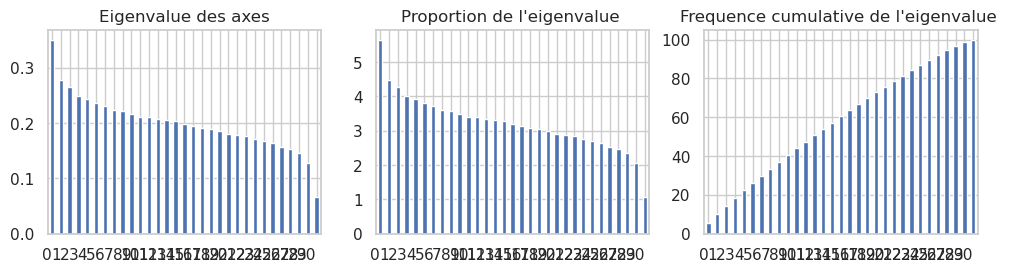

In [108]:
# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

eig.iloc[:,0].plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
eig.iloc[:,1].plot(kind='bar', ax=axes[1], title="Proportion de l'eigenvalue ")
eig.iloc[:,2].plot(kind='bar', ax=axes[2], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

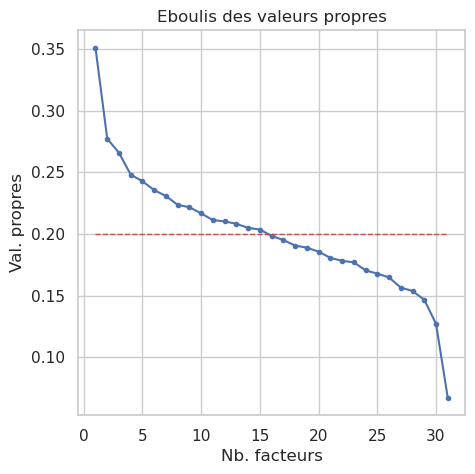

In [109]:
#éboulis des v.p.

xvalues = len(acm.eig_[0])+1

fix,ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,xvalues),acm.eig_[0],".-")
ax.set_xlabel("Nb. facteurs")
ax.set_ylabel("Val. propres")
plt.title("Eboulis des valeurs propres")
#seuil - Règle de Kaiser
ax.plot([1,xvalues-1],[1/p,1/p],"r--",linewidth=1)
plt.show()

*Diagramme d'éboulis*. Représentation graphique ayant pour but d'identifier un point d'inflexion dans une courbe de la variance. Le nom donné à ce type de graphique vient de la ressemblance de la courbe avec le profil des éboulis (scree) au bas d'une falaise. [DataFranca, Diagramme d'éboulis, 2024](https://datafranca.org/wiki/index.php?title=Diagramme_d%27%C3%A9boulis&oldid=93502)

In [110]:
### Correction de Benzecri, cf. Rakotomalala, Pratique, p.313sqq

#somme en colonne
#récupérer les valeurs propres supérieur à (1/p)
lambada = acm.eig_[0][acm.eig_[0]>1/p]
#print(lambada)

#appliquer la correction
lambada_prim = ((p/(p-1))*(lambada-1/p))**2
#print(lambada_prim)

#faire la somme
S_prim = np.sum(lambada_prim)
#print('u',S_prim)

#et produire les pourcentages
percent_prim = lambada_prim/S_prim*100

#affichage
bzc = pd.DataFrame(np.transpose(np.array([lambada_prim,percent_prim,
                                np.cumsum(percent_prim)])),columns=['Val.P','freq','Cumul_freq'],
                                index=range(1,len(percent_prim)+1))
print(bzc)

       Val.P       freq  Cumul_freq
1   0.035583  55.497324   55.497324
2   0.009309  14.518478   70.015802
3   0.006761  10.544896   80.560699
4   0.003613   5.634770   86.195468
5   0.002844   4.435539   90.631008
6   0.001975   3.080587   93.711595
7   0.001474   2.299022   96.010617
8   0.000869   1.355292   97.365909
9   0.000732   1.142167   98.508076
10  0.000435   0.677819   99.185895
11  0.000197   0.307287   99.493182
12  0.000162   0.251896   99.745078
13  0.000106   0.164667   99.909745
14  0.000038   0.058950   99.968695
15  0.000020   0.031305  100.000000


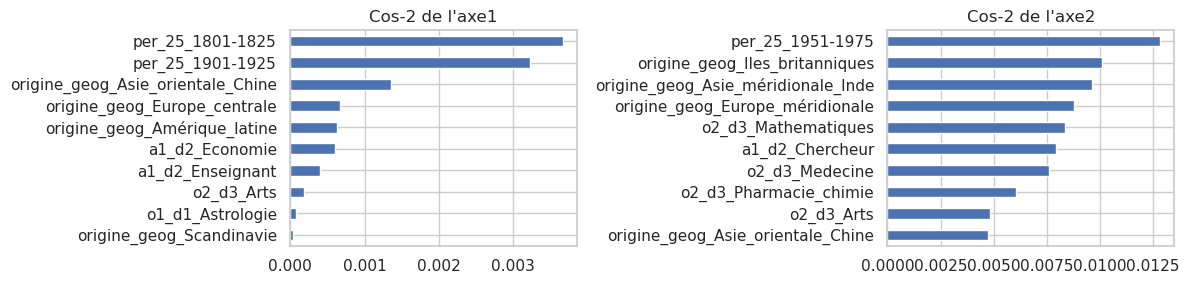

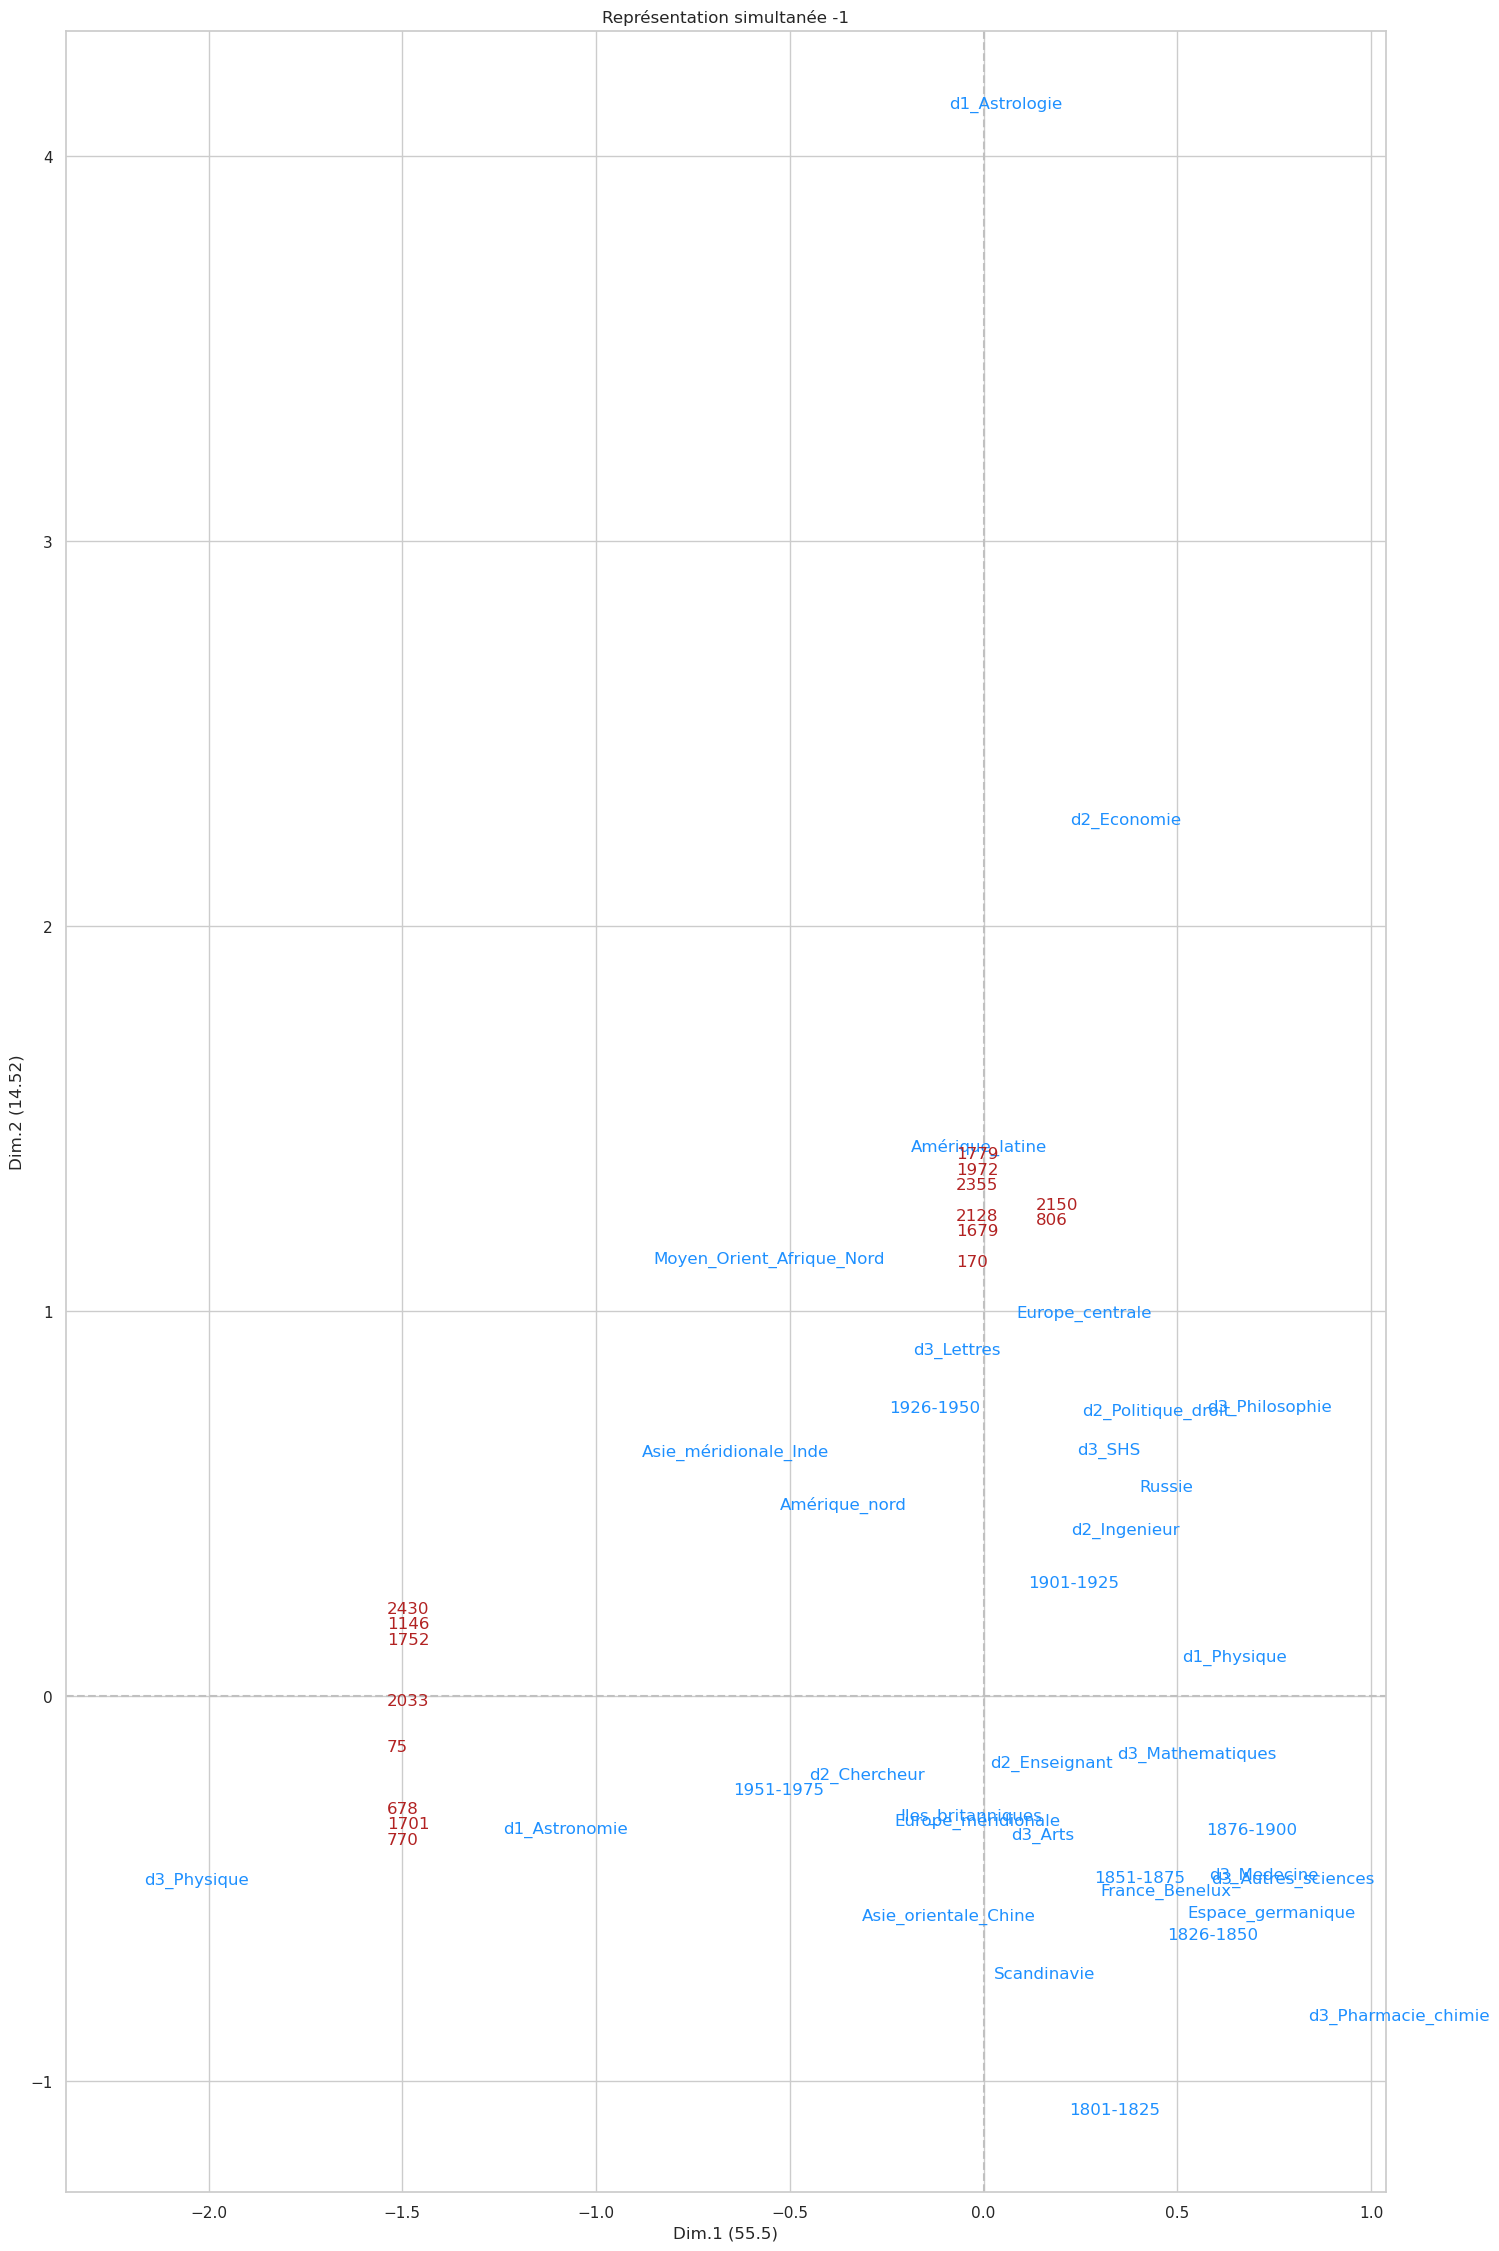

|      | per_25    | origine_geog    | o1            | a1            | o2          |
|-----:|:----------|:----------------|:--------------|:--------------|:------------|
|  806 | 1926-1950 | Europe_centrale | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 2150 | 1926-1950 | Europe_centrale | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
|  170 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 1679 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 2128 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 2355 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 1972 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
| 1779 | 1926-1950 | Amérique_nord   | d1_Physique   | d2_Ingenieur  | d3_Lettres  |
|  770 | 1951-1975 | Amérique_nord   | d1_Astronomie | d2_Enseignant | d3_Physique |
| 1701 | 1951-1975 | Amérique_nord   | d1_Astronomie | d2_Enseign

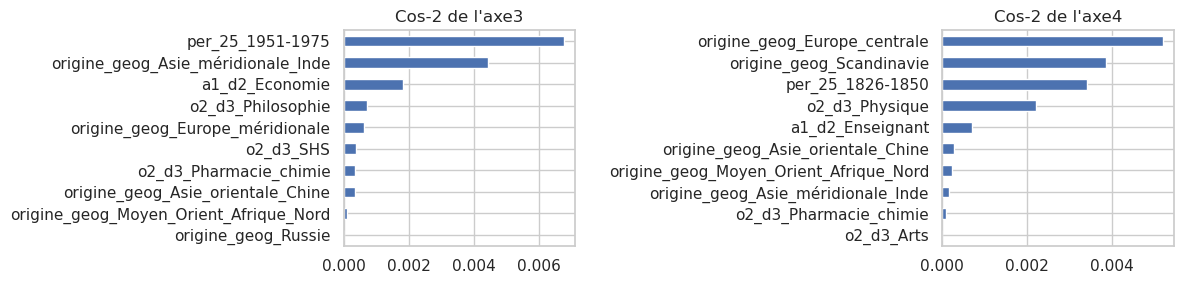

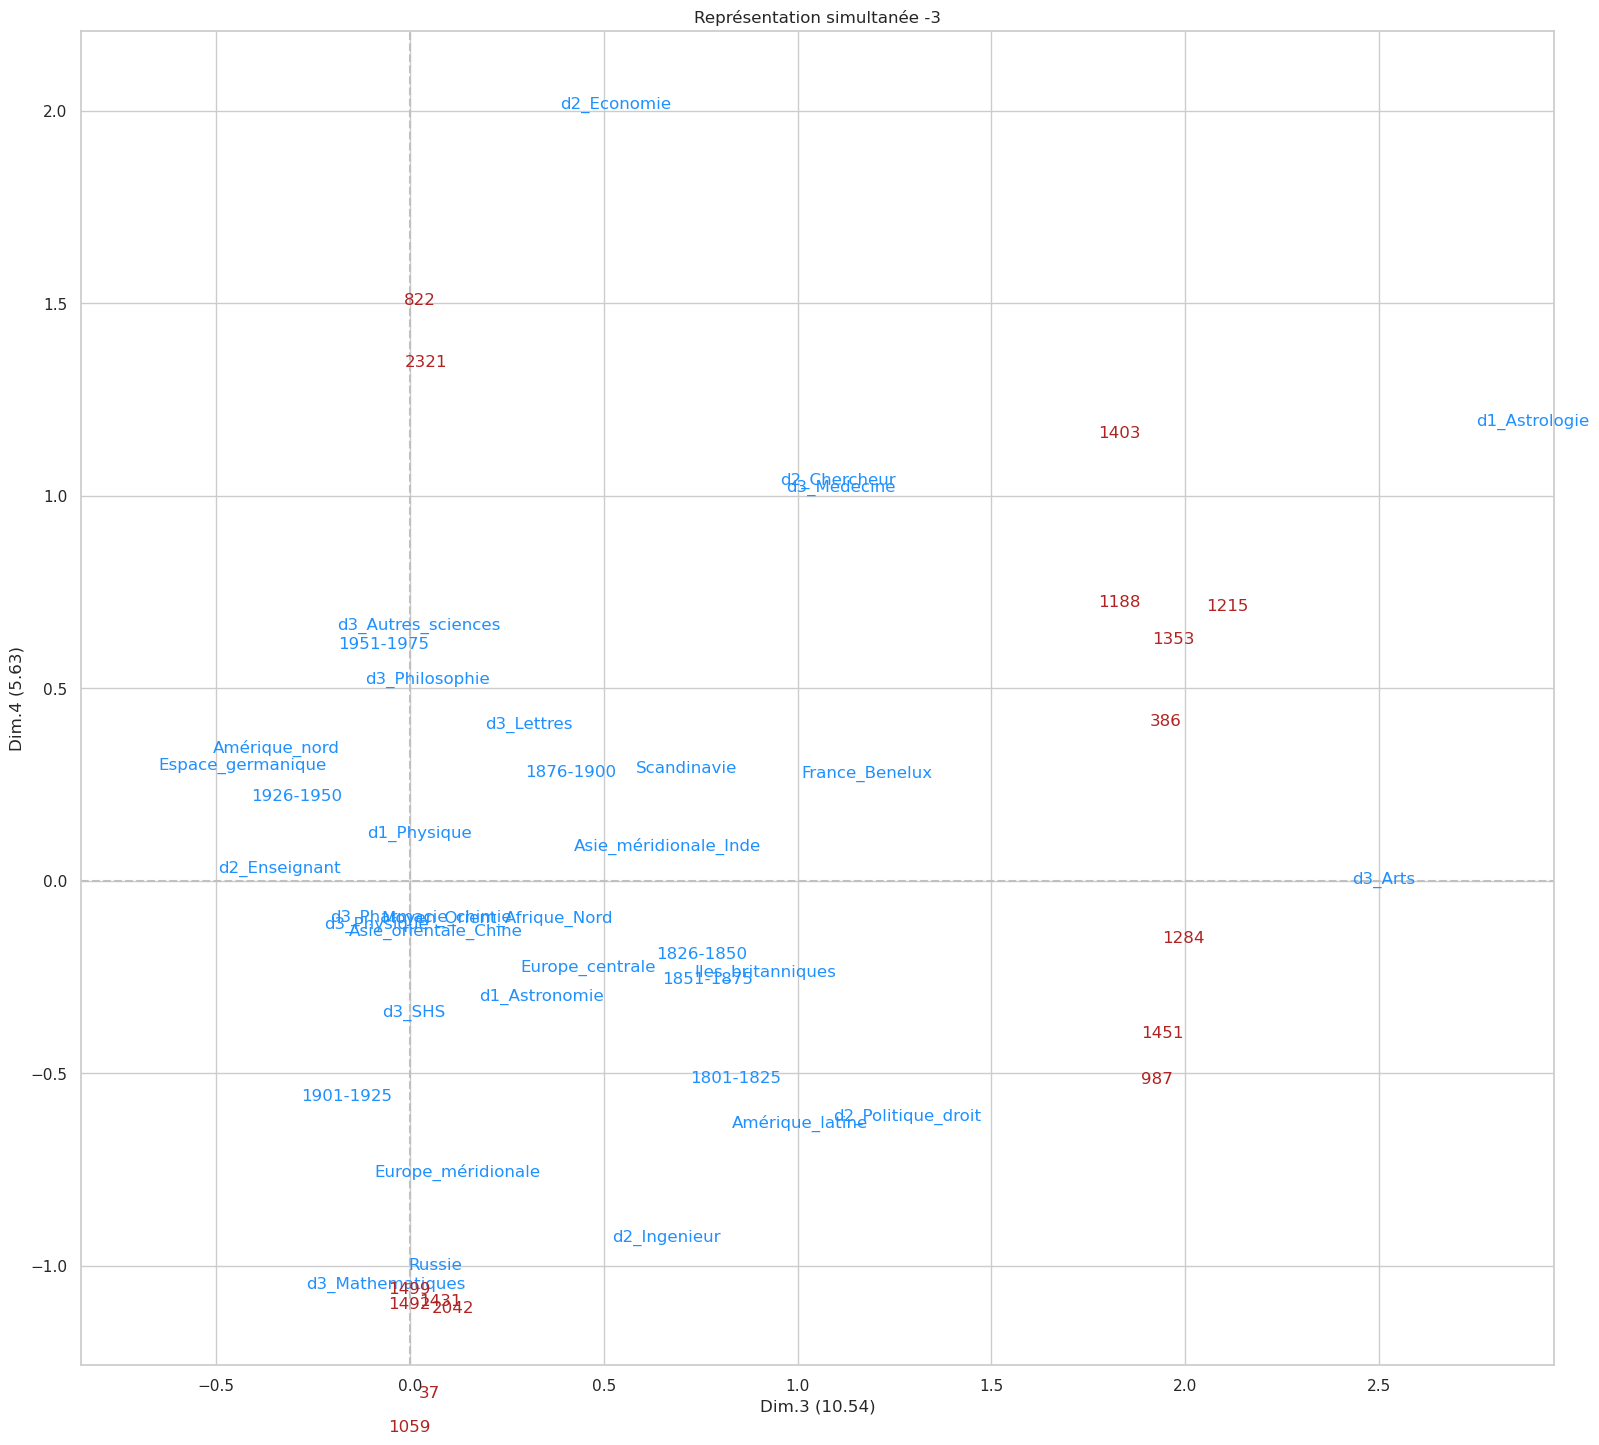

|      | per_25    | origine_geog       | o1            | a1                 | o2                 |
|-----:|:----------|:-------------------|:--------------|:-------------------|:-------------------|
|  987 | 1801-1825 | France_Benelux     | d1_Astronomie | d2_Ingenieur       | d3_Arts            |
| 1451 | 1801-1825 | France_Benelux     | d1_Astronomie | d2_Ingenieur       | d3_Arts            |
| 1215 | 1801-1825 | France_Benelux     | d1_Astronomie | d2_Chercheur       | d3_Arts            |
|  386 | 1826-1850 | France_Benelux     | d1_Physique   | d2_Chercheur       | d3_Arts            |
| 1353 | 1851-1875 | France_Benelux     | d1_Physique   | d2_Chercheur       | d3_Arts            |
| 1284 | 1876-1900 | France_Benelux     | d1_Astronomie | d2_Politique_droit | d3_Arts            |
| 1188 | 1876-1900 | France_Benelux     | d1_Physique   | d2_Chercheur       | d3_Arts            |
| 1403 | 1876-1900 | France_Benelux     | d1_Physique   | d2_Chercheur       | d3_Arts            |


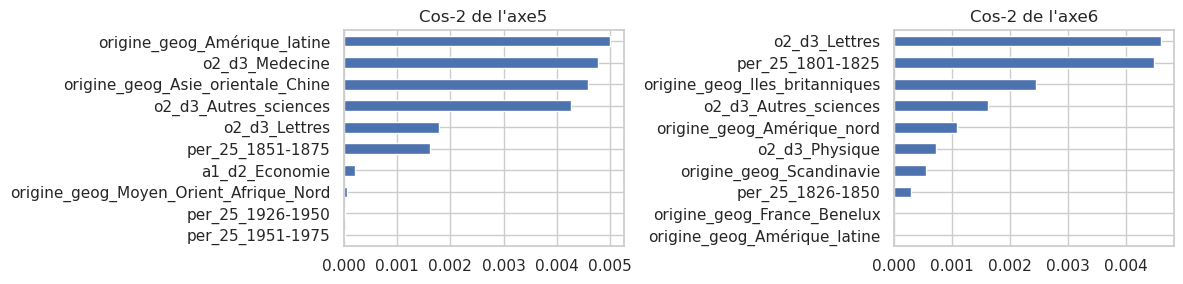

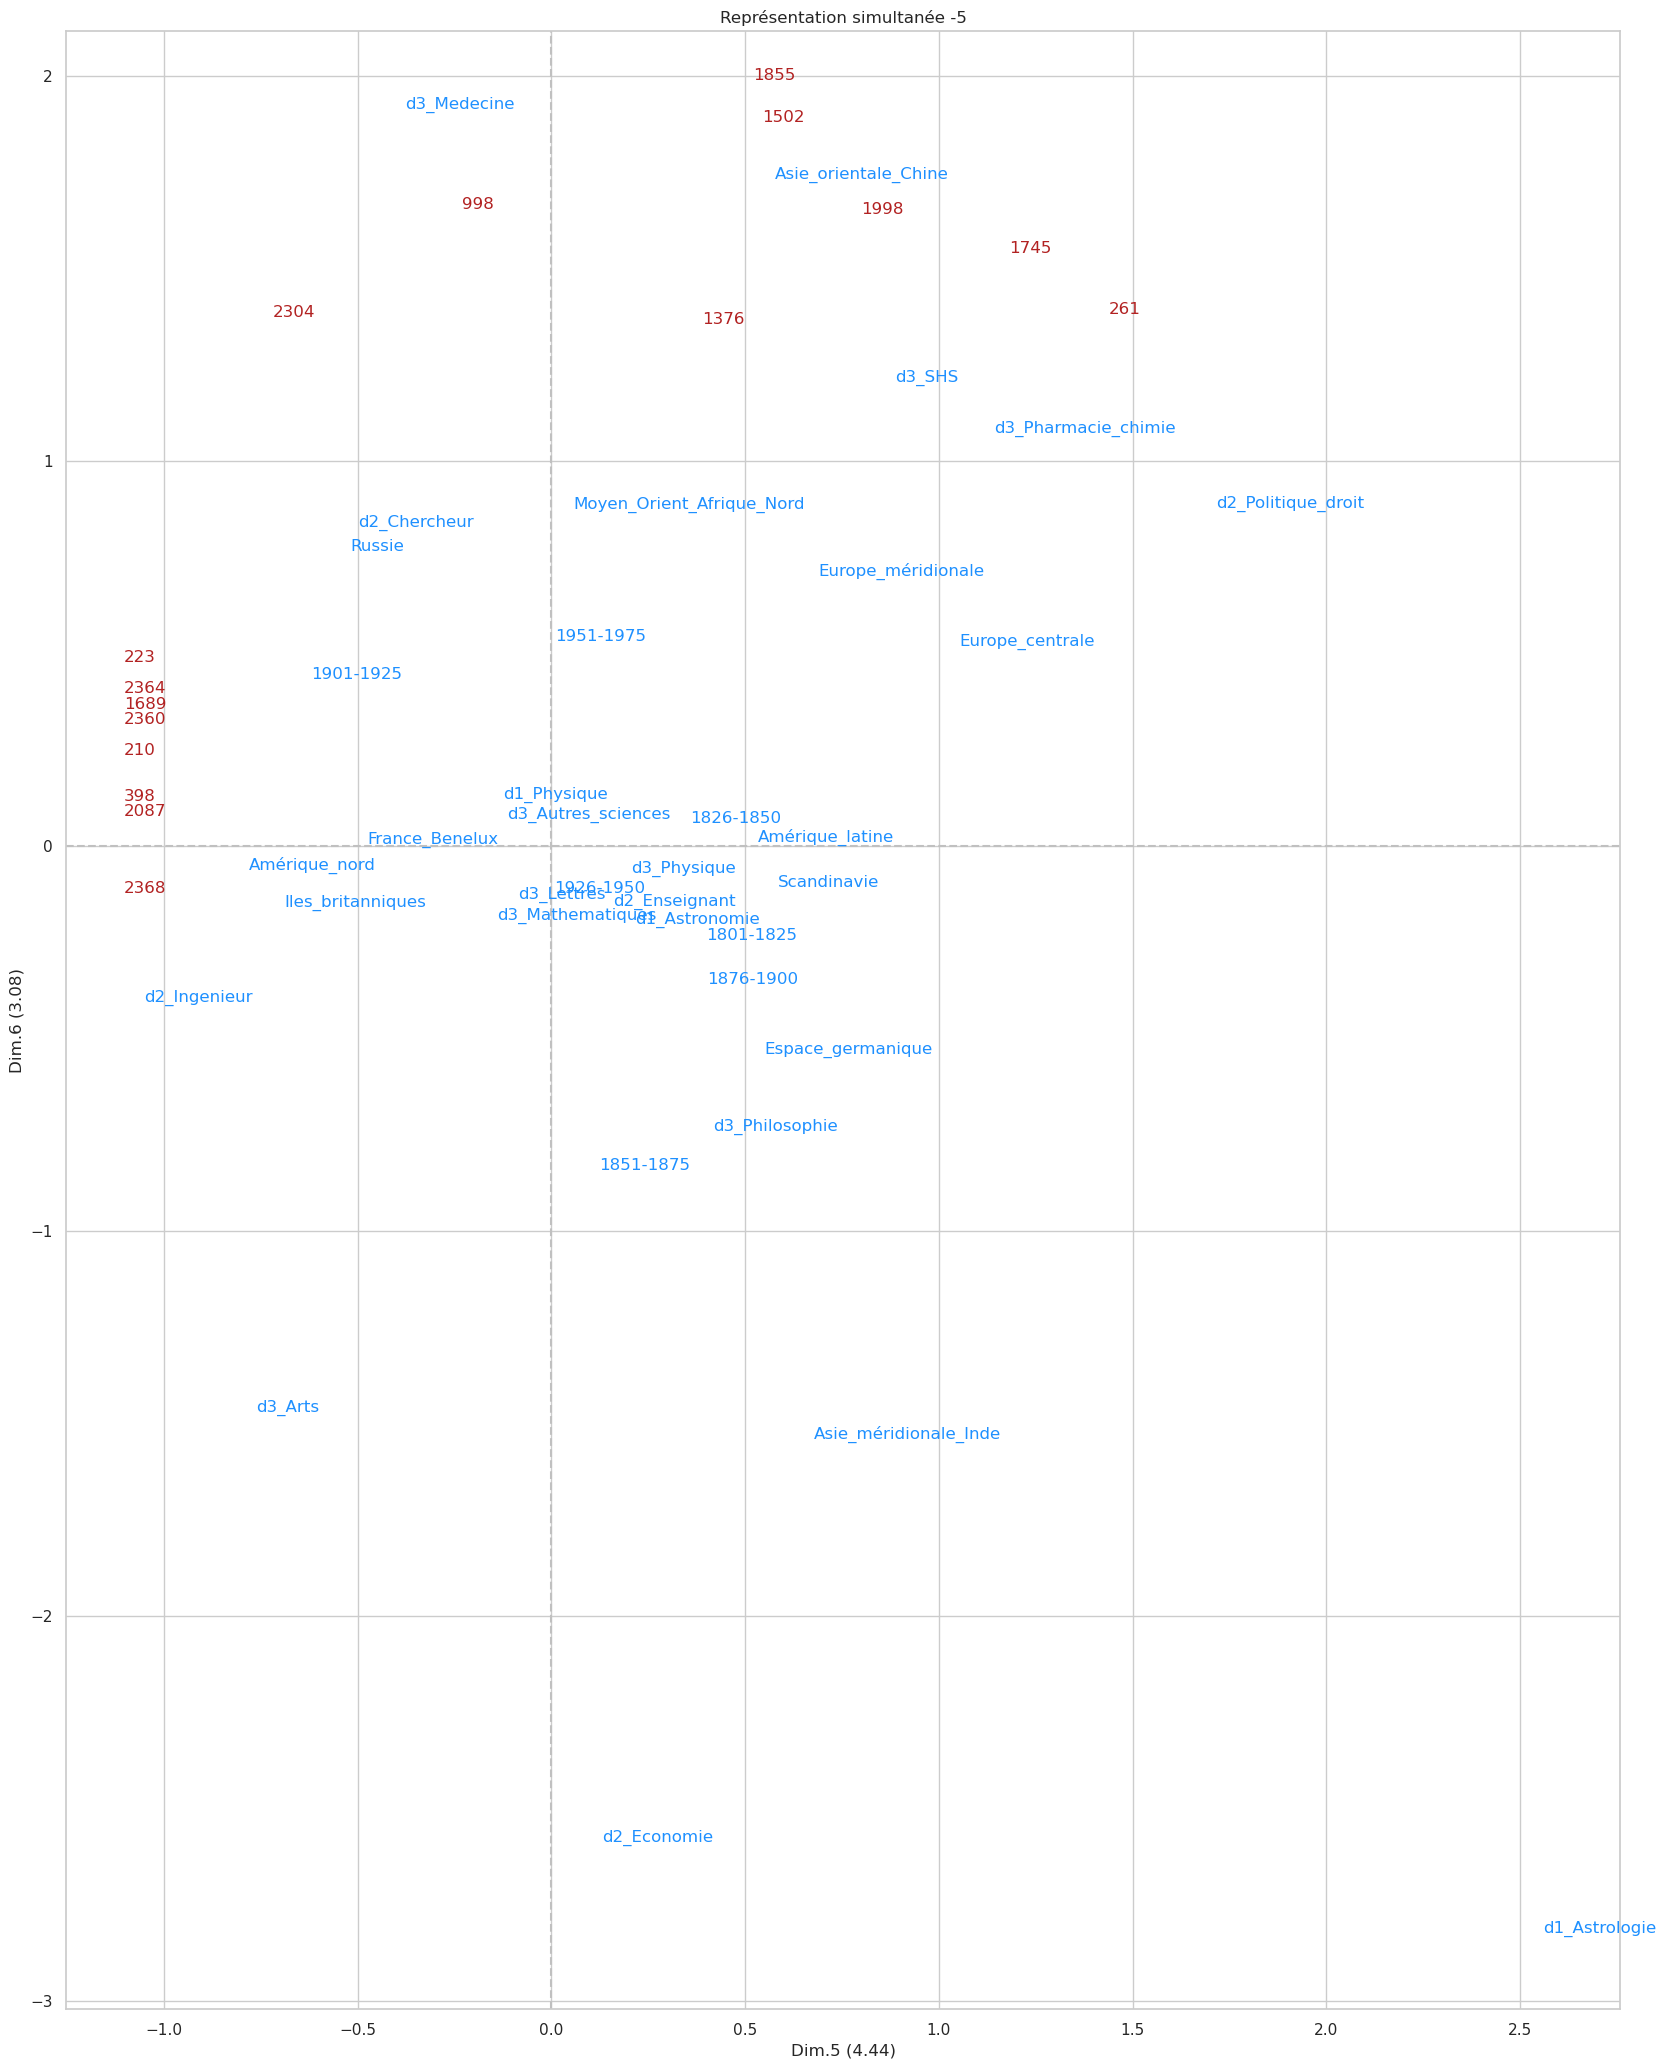

|      | per_25    | origine_geog       | o1          | a1                 | o2               |
|-----:|:----------|:-------------------|:------------|:-------------------|:-----------------|
| 2368 | 1901-1925 | Amérique_nord      | d1_Physique | d2_Ingenieur       | d3_Mathematiques |
|  998 | 1901-1925 | Europe_centrale    | d1_Physique | d2_Chercheur       | d3_Medecine      |
| 2087 | 1901-1925 | Amérique_nord      | d1_Physique | d2_Ingenieur       | d3_Mathematiques |
|  398 | 1901-1925 | Amérique_nord      | d1_Physique | d2_Ingenieur       | d3_Mathematiques |
| 1745 | 1901-1925 | Europe_centrale    | d1_Physique | d2_Politique_droit | d3_SHS           |
|  210 | 1901-1925 | Amérique_nord      | d1_Physique | d2_Ingenieur       | d3_Mathematiques |
| 1855 | 1901-1925 | Europe_méridionale | d1_Physique | d2_Politique_droit | d3_Medecine      |
| 2360 | 1901-1925 | Amérique_nord      | d1_Physique | d2_Ingenieur       | d3_Mathematiques |
| 1689 | 1901-1925 | Amérique_nord      

In [111]:
# Mapping des points colonnes

i = 1
dfc = acm.col_topandas()

df_rows = acm.row_topandas()




### avec la correction de Benzecri, 
# 3 axes apportent 95%  de l'information
while i < 6:    

    #c1 = 'col_contrib_dim' + str(i)  
    #c2 = 'col_contrib_dim' + str(1+i)

    c1 = 'col_cos2_dim' + str(i)  
    c2 = 'col_cos2_dim' + str(1+i)


    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Cos-2 de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Cos-2 de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()


    # rc1 = 'row_contrib_dim' + str(i)  
    # rc2 = 'row_contrib_dim' + str(1+i)
    rc1 = 'row_cos2_dim' + str(i)  
    rc2 = 'row_cos2_dim' + str(1+i)

    ### Filtrer les individus donnant la plus grande contribution à l'axe
    # On retient les individus les mieux représentés sur chaque axe
    rcv1 = df_rows[rc1].sort_values(ascending=False)[:8].index
    rcv2 = df_rows[rc2].sort_values(ascending=False)[:8].index

    lrc = list(set(list(rcv1) + list(rcv2)))


    min_d1 = min(dfc['col_coord_dim' + str(i)])-0.2
    max_d1 = max(dfc['col_coord_dim' + str(i)])+0.2
    min_d2 = min(dfc['col_coord_dim' + str(i+1)])-0.2
    max_d2 = max(dfc['col_coord_dim' + str(i+1)])+0.2

    #représentation simultanée
    #fig,ax = plt.subplots(figsize=(20, 20))
    fig,ax = plt.subplots(figsize=((min_d1*-1 + max_d1)*5, (min_d2*-1 + max_d2)*5))
    ax.axis([min_d1,max_d1,min_d2,max_d2])
    ax.plot([min_d1,max_d1],[0,0],color='silver',linestyle='--')
    ax.plot([0,0],[min_d2,max_d2],color='silver',linestyle='--')

    ax.set_xlabel("Dim."+str(i)+" ("+ str(round(bzc.freq.iloc[(i-1)],2))+")")
    ax.set_ylabel("Dim."+str(i+1)+" ("+ str(round(bzc.freq.iloc[i],2))+")")

    plt.title("Représentation simultanée -" + str(i))
    for i1 in range(df.shape[1]):
        ax.text(acm.col_coord_[i1,(i-1)],acm.col_coord_[i1,i],df.columns[i1],color='dodgerblue')
    
    ### espacer légèrement les individus
    a = -0.08
    for i2 in lrc:
        ax.text(acm.row_coord_[i2,(i-1)],acm.row_coord_[i2,i]+ a,df.index[i2],color='firebrick')        
        a += 0.04
    plt.show()

    print(DActives_ct.iloc[lrc].sort_values(by='per_25').to_markdown())

    i += 2